# 从零开始学习DMFF

<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:1rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b><i>Copyright 2023 @ Authors</i></b><br/>
        <i>作者：
            <b>
            <a href="mailto:vinnie_fw@pku.edu.cn">冯维 📨 </a>，
            韩言博，
            陈俊敏，
            余旷* 
            </b>
        </i>
        <br/>
        <i>日期：2023-05-29</i><br/>
        <i>共享协议：</a>本作品采用<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">知识共享署名-非商业性使用-相同方式共享 4.0 国际许可协议</a>进行许可。</i>
    </p>
</div>

**准确而高效地描述原子、分子、粗粒化粒子间的相互作用是多尺度建模的重要问题之一。尽管以DeePMD为代表的神经网络方法在材料模拟等领域取得了较大的成功，基于物理的分子力场在生物和有机高分子等领域的模拟中仍然扮演着关键作用。DeepModeling社区的开发者们发起的可微分分子力场（Differentiable Molecular Force Field, DMFF）优化平台希望通过自动微分技术打造全新的生产级力场计算引擎，以帮助解决参数调优困难、复杂力场计算等开发过程中的诸多痛点问题，达成分子力场参数的自动调优，以及复杂力场分子动力学（MD）的快速实现。**

**DMFF是完全基于可微分编程框架技术搭建的分子力场开发框架：通过DMFF，我们可以将各种物理力场和模拟计算流视为人工智能模型的自然延伸，以第一性原理或实验数据为输入，采用先进机器学习算法（而非人类经验）反向矫正、优化物理模型参数。由此，我们期望摆脱传统力场研究中手动调参和手动写MD代码的小作坊模式，并为自动化可持续的力场开发工作流奠定基础。**

关于DMFF项目的更多介绍，详见：https://mp.weixin.qq.com/s/eVXTr1eU1-dGbC5UFybr0g

注：JAX、DMFF等均还在快速开发迭代中，本Notebook在DMFF0.2.0上运行通过。
> **可使用 Bohrium 平台 dmff:0.2.0-notebook 镜像直接运行** 

# 写在前面

分子体系是一类非常重要的体系：生物大分子、药物分子、工业上用的各种涂料、COF等多孔材料、电池中的高分子和小分子电解质等等都是有机分子。生物大分子结构预测、药物筛选、有机材料筛选和设计等工业界关心的问题，都或多或少地依赖于对分子体系的分子动力学(MD)模拟。尽管当前MD的应用早就超出了分子体系的范畴，但对于分子体系的模拟，依然是MD最核心的应用场景之一。

分子体系的模拟通常有三种方法：采用具有特定形式的经典势函数来描述原子与分子间的相互作用的经典分子动力学CMD、采取基于第一性原理的计算方法，从最基本的物理量从头计算相互作用力的从头算分子动力学AIMD以及时下最为新兴的机器学习分子动力学MLMD。其中传统工业中应用最为广泛的是经典分子动力学。管实现路径有所差异，三种方法的核心都是拟合微观层次的相互作用或者说势函数，从而准确预测宏观性能。而经典分子动力学中的势函数，以分子力场的数学形式给出。

![s](https://i.postimg.cc/DfCQpdsd/MD-3way.jpg)

## 什么是分子力场

上面提到，分子体系的模拟中最重要的就是刻画体系势能函数、描述相互作用。在经典分子动力学模拟(CMD)中，势能函数遵循固定的数学形式，而力场即以数学函数的形式给出了分子间与分子内相互作用势。目前工业界常用的传统力场，比如OPLS、GAFF等，基本上具有相同的形式：

![s](https://i.postimg.cc/SKJjsCjq/interact.jpg)

总能量可以被拆分为成键和非键部分，成键部分天然是分子内坐标（键长、键角、二面角）的函数，而非键部分（可被进一步拆分为范德华作用和点电荷相互作用）天然是原子间距的函数。这一形式几乎是整个工业界都在使用的标准形式。然而，目前投入工业化应用的分子力场普遍面临着这样几个问题：
- 缺乏可移植性和预测能力：研究新体系时，在真正跑出结果之前，恐怕谁都不确定哪个力场结果更好。除了靠“经验”，谁也说不清楚力场应该怎么选。
- 参数缺少唯一性和一致性：经常出现多套完全不同的参数能给出相似的宏观预测，因此不能仅通过宏观数据确定微观上哪套参数更为合理。同时，我们也常常能看到非常相似的体系，力场参数却完全不同，因此不同课题组发展的力场往往不能组合使用。
在过去的几十年里，发展经验力场、提高计算精度是一个古老又新兴的课题，准确高效地描述原子间的相互作用，并确立一条适用于拟合绝大多数体系的分子力场的技术路线一直是分子力场乃至分子动力学研究者们的追求方向。而力场中各项参数的优化，长期依赖人为干涉与“经验化”调参方法，这让经验力场的拟合在可靠性与效率上都不能得到保证。而人工智能浪潮下作为底层技术之一的“自动微分”技术，为这一难题提供了新的解决策略：基于自动微分技术的DMFF(Differentiable Molecular Force Field)应运而生，有望成为分子力场开发者们的“屠龙宝刀”。

## 自动微分技术与DMFF
自动微分技术是一种精度高、普适性强的计算机求导新方法。它遵循数学中链式法则，实现复合函数的求导，在计算程序时，依照计算图可以到追踪每一个数据的求导链，并最终实现计算输出结果对输入端的微分。
自动微分技术可以帮助神经网络模型的优化。在模型训练中，需要通过反向传播计算结果端对输入端的微分，利用梯度下降优化模型参数，自动微分框架可以很好地实现这一点。凭借对高维参数的高效优化能力，自动微分技术不光可以用于神经网络模型中，也可以用到其他任何此类“输入模型参数→套用模型计算→得到计算结果”的框架中。而分子动力学模拟正是这样的流程框架。因此，完全可以借助自动微分技术，利用实验或是第一性原理计算数据作为参考，通过反向传播计算输出结果对于输入参数的微分，从而实现力场参数的优化。

![s](https://i.postimg.cc/Gp1S3JXT/Autod.jpg)

自动微分技术助力分子动力学模拟已经有了若干尝试，包括TorchMD、JAX-MD与SPONGE。然而，分子动力学模拟中的深度计算图往往会带来一些其他问题，如从输出结果到输入端微分的反向传播过程需要付出巨大代价；另一方面，为力场快速实现与参数优化而设计的模拟引擎仍然缺位，分子力场的开发者仍然迫切需要对更多力场函数形式以及更多类型的对象函数的全面支持。而DMFF则为解决这些问题提供了一条新的路径。

![s](https://i.postimg.cc/CLkQ3QNp/dmffLogo.jpg)

DMFF在力场模型的全面快速实现基础上，提供了对体系能量、力以及热动力学量的可微分估计。基于这些估计量，可以定义相应目标函数，从而实现自动优化流程。同时，上面提到，分子动力学模拟中跨越整条轨迹的深度计算图在时间与计算代价上都是巨大的。而这一缺憾可以通过轨迹重新加权的方案来避免。在DMFF中，重加权算法被引入MBAR方法中，并拓展了平均性质与自由能的可微分估计量。关于这一方法，我们在以实际案例为大家进行展示。
通过DMFF，我们对分子力场开发的两大难题作出回应：
- 如何保证分子动力学模拟过程中复杂力场的快速实现与迭代
- 如何提升高维度函数中优化参数的效率以及这一过程的自动化程度，并提升参数的可迁移性
而在我们最新发布的DMFF0.2.0版本中，我们尝试探索出了一条力场参数自动优化的路径，相应的工作流在比较简单的小分子体系与较为复杂的电解液体系中都得到了验证。我们会通过notebook“手把手”带你体验DMFF实现力场参数自动优化的完整工作流。同时，我们以notebook为教学模版，带领大家真实体验DMFF 对于力场开发的推动作用。

# 目录
* [1. 快速上手DMFF](#1)
    * [1.0 引入依赖，准备文件](#1-1)
    * [1.1 读入现有力场参数和拓扑](#1-2)
    * [1.2 计算](#1-3)
    * [1.3【回顾】DMFF的基本界面和使用要点](#1-4)
* [2. 势函数的生成与拓展](#2)
    * [2.1 多级矩可极化力场](#2-1)
    * [2.2 利用后端函数进行拓展](#2-2)
 * [3. DMFF自下而上拟合](#3)
    * [3.1 问题介绍](#3-1)
    * [3.2 势函数定义](#3-2)
    * [3.3 准备势函数的输入（近邻表等）](#3-3)
    * [3.4 载入数据](#3-4)
    * [3.5 定义损失函数](#3-5)
    * [3.6 能量优化](#3-6)
* [4.使用DMFF进行液体碳酸二甲酯（DMC）的力场优化](#4)
    * [4.1 介绍](#4-1)
    * [4.2 定义势函数](#4-2)
    * [4.3 定义OpenMM采样器](#4-3)
    * [4.4 初始MD采样](#4-4)
    * [4.5 定义性质计算函数](#4-5)
    * [4.6 读入数据并进行比对](#4-6)
    * [4.7 Estimator 初始化](#4-7)
    * [4.8 定义目标系综](#4-8)
    * [4.9 定义损失函数](#4-9)
    * [4.10 优化器准备及优化循环](#4-10)
* [5. 总结与展望](#summary)

## 1. 快速上手DMFF <a id ='1'></a>
本案例主要由韩言博贡献
### 1.0 引入依赖，准备文件 <a id ='1-1'></a>

我们先配置运行环境，并引入需要用到的势函数

In [1]:
#! pip install matplotlib pymbar optax
#! conda install mdtraj -y
! if [ ! -e DMFF ];then git clone https://gitee.com/deepmodeling/DMFF.git;fi
! git config --global --add safe.directory `pwd`/DMFF
! cd DMFF && git checkout devel
! export XLA_PYTHON_CLIENT_PREALLOCATE=FALSE
#! cd DMFF && python setup.py install

Already on 'devel'
Your branch is up to date with 'origin/devel'.


除去 DMFF，我们还需要使用的包有 JAX、OpenMM；
- OpenMM：管理核心的力场文件和参数数据（力场参数读取的前端）
- JAX：可微分框架（力场计算的后端引擎）

同时，在后面的案例中我们还会用到一些其他库以及轨迹分析软件如mdtraj等，这里一并引入


In [2]:
import sys
import numpy as np
import jax
import jax_md
import jax.numpy as jnp
from jax import value_and_grad, jit, vmap
import openmm as mm
import openmm.app as app
import openmm.unit as unit
import dmff
from dmff import Hamiltonian, NeighborList
from dmff.api import Hamiltonian
from dmff.common import nblist
from dmff.optimize import MultiTransform, genOptimizer
from dmff.mbar import MBAREstimator, SampleState, TargetState, Sample, OpenMMSampleState, buildTrajEnergyFunction
import pickle
from pprint import pprint
import optax
import mdtraj as md
from itertools import combinations
import matplotlib.pyplot as plt

进入工作文件夹

In [3]:
import os
os.chdir(os.path.join("DMFF","examples", "classical"))

### 1.1 读入现有力场参数和拓扑 | OpenMM前端 <a id ='1-2'></a>

如果是OpenMM中使用力场，我们会通过其`ForceField`类来加载力场参数等，即如
```python
app.Topology.loadBondDefinitions("lig-top.xml")
pdb = app.PDBFile('lig.pdb')
pdb_system = pdb.topology

forcefield = ForceField('someforcefield.xml')
```
DMFF中有和 OpenMM 的 `ForceField` 类似的，读取力场参数的功能类 `Hamiltonian`，可以定义更广义的体系势能函数，同时又兼容对现有力场参数的读取：

- 我们可以使用OpenMM主要读入PDB和拓扑：
    - 拓扑（`log-top.xml`）
    - 坐标PDB（`lig.pdb`）
- 使用DMFF的Hamiltonian读入力场参数，以便建立可微分势能函数
    - GAFF 力场文件 （`gaff-2.11.xml`）
    - 对应分子的额外参数（指派的电荷） （`lig-prm.xml`）
    
DMFF势函数，除Hamiltonian名称外，和 OpenMM 的用法是相同的，OpenMM 力场的 XML 文件也可直接复用。

In [4]:
app.Topology.loadBondDefinitions("lig-top.xml")
pdb = app.PDBFile("lig.pdb")
ff = Hamiltonian("gaff-2.11.xml", "lig-prm.xml")
potentials = ff.createPotential(pdb.topology)

在DMFF中，势函数参数和计算将会由JAX管理，例如上述DMFF势函数包括了在DMFF中重新实现的 HarmonicBondForce、HarmonicAngleForce、PeriodicTorsionForce、NonbondedForce，
其中的参数是JAX包装的Array对象，例如我们如果定义：
```python
jnp.array([1.])
```
会得到一个`DeviceArray`类型。这个类型的接口和numpy.darray()类型类似，都是高性能的数组/矩阵，较numpy不同的是JAX的jax.numpy.array()可以扩展到GPU/TPU上使用，能够很好的支持自动微分。

In [5]:
for k in potentials.dmff_potentials.keys():
    pot = potentials.dmff_potentials[k]
    print(k, pot)

params = ff.getParameters()
# print(params.keys()) # GAFF2有四种 Force，'NonbondedForce', 'HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce'
nbparam = params['NonbondedForce']
for k,v in nbparam.items():
    print(k, type(v), v if v.shape[0]<10 else f"shape: {v.shape}")

HarmonicBondForce <function HarmonicBondJaxGenerator.createForce.<locals>.potential_fn at 0x7f330c3d77f0>
HarmonicAngleForce <function HarmonicAngleJaxGenerator.createForce.<locals>.potential_fn at 0x7f330c3d7c70>
PeriodicTorsionForce <function PeriodicTorsionJaxGenerator.createForce.<locals>.potential_fn at 0x7f330c3d7d00>
NonbondedForce <function NonbondedJaxGenerator.createForce.<locals>.potential_fn at 0x7f32ec5817e0>
sigfix <class 'jaxlib.xla_extension.DeviceArray'> []
epsfix <class 'jaxlib.xla_extension.DeviceArray'> []
sigma <class 'jaxlib.xla_extension.DeviceArray'> shape: (97,)
epsilon <class 'jaxlib.xla_extension.DeviceArray'> shape: (97,)
charge <class 'jaxlib.xla_extension.DeviceArray'> shape: (66,)
coulomb14scale <class 'jaxlib.xla_extension.DeviceArray'> [0.8333333]
lj14scale <class 'jaxlib.xla_extension.DeviceArray'> [0.5]
bcc <class 'jaxlib.xla_extension.DeviceArray'> []
vsite_types <class 'jaxlib.xla_extension.DeviceArray'> []
vsite_distances <class 'jaxlib.xla_extensi

### 1.2 计算 | JAX可微分后端 <a id ='1-3'></a>

上述定义的势函数的计算中，我们需要这样几个参数：

- **坐标** positions: 这个只要使用pdb中的坐标即可



- **体系模拟的盒子定义** box: 我们的PDB文件中没有定义 box，所以需要加上 box 大小的定义；（当然，使用None也会得到结果，因为我们的体系并不涉及周期边界）

- **原子近邻表定义** pairs: GAFF2势函数计算能量的接口同时也需要输入Neighborlist以便计算nonbondforce，故也可以使用NeighborList类来得到pairs

然后就可以传递给 potentials.dmff_potentials 中保存的，由`generator`解析XML中的力场参数生成的`get_energy`函数来计算相应的能量，例如可以计算`NonbondedForce`能量：

In [6]:
positions = jnp.array(pdb.getPositions(asNumpy=True).value_in_unit(unit.nanometer))

box = jnp.array([
    [10.0,  0.0,  0.0],
    [ 0.0, 10.0,  0.0],
    [ 0.0,  0.0, 10.0]
])
# box=None # 使用这个也可以

nbList = NeighborList(box, r_cutoff=4, covalent_map=ff.getGenerators()[-1].covalent_map)
nbList.allocate(positions)
pairs = nbList.pairs

# pairs的格式是[原子索引1, 原子索引2, nbond]，nbond为0表示没有bond
# print(pairs)

nbfunc = potentials.dmff_potentials['NonbondedForce']

# 可以用 inspect 看看，`nbfunc`是一个【函数】,而inspect.signature()方法会告诉我们这个函数的输入参数有哪些
# 
# import inspect
# print(inspect.signature(nbfunc))

nbene = nbfunc(positions, box, pairs, params)
print(nbene)

-425.40488


或是计算体系总能量，对于我们上面定义的体系，其能量为：

$$E_{\rm{total}}^{\rm{GAFF2}}=E_{\rm{bond}}+E_{\rm{angle}}+E_{\rm{torsion}}+E_{\rm{nonbond}}$$

使用之前的 potential，调用`getPotentialFunc()`方法，即可获得计算总能量的函数。

In [7]:
efunc = potentials.getPotentialFunc()
params = ff.getParameters()
totene = efunc(positions, box, pairs, params)
print(totene)

-52.358948


到此为止，我们计算体系能量的方法都还和 OpenMM 中的方式没有大的区别。

JAX作为计算后端的最大优势，则在于我们可以使用`jax.grad`函数来获得函数的导函数，其语法为 `jax.grad(func, argnums)`，含义为对函数的第argnums参数求（偏）导。  
我们拿到的总能量计算函数`efunc`的接口是 [坐标、box、成键对、力场参数] （DMFF的经典力场实现是这组参数，**但不同Force可能有不同定义**）

In [8]:
# 可以使用inspect.signature查看函数接口签名
# import inspect
# print(inspect.signature(efunc))

我们“对函数求（偏）导函数”的操作，求总能量对坐标的偏导数，即可用于计算分子中的原子受力

$$\frac{\partial{E_{\rm{total}}}}{\partial{\mathbf{Z_i}}}=-\mathbf{F_i}, \ i=x,y,z$$

（注意力是能量导数反方向，所以需要取负）

In [9]:
pos_grad_func = jax.grad(efunc, argnums=0)
force = -pos_grad_func(positions, box, pairs, params)
print(force)

[[  803.5053     3400.27       -661.98413  ]
 [ 1150.3483    -2973.8022     4723.1094   ]
 [-1806.3174    -1691.2512    -4400.671    ]
 [-1975.181     -3796.7463    -2135.0186   ]
 [  300.95966   -2505.3462     1973.2803   ]
 [ 1417.9027     4929.0312      690.1204   ]
 [-1214.6167     -752.06226    -728.6687   ]
 [  506.18085   -1762.1459     -183.49246  ]
 [  666.4907      -96.466      1381.9845   ]
 [-1764.406     -1823.6426    -1339.2583   ]
 [  716.9508     2224.645      -611.07526  ]
 [ -668.10223   -2633.5884      -45.521576 ]
 [  525.2708     1892.7621     -324.64764  ]
 [ -222.92917   -1252.5643     1038.3877   ]
 [ 1050.3809     1406.0747      859.39716  ]
 [ -150.03757    -816.84314    -112.414795 ]
 [-2460.543      1360.3517     -796.9952   ]
 [-1690.8473    -4545.091        67.75354  ]
 [ 2421.7532     2531.319       411.40106  ]
 [-1881.5691     2700.4482     -938.7882   ]
 [ 2230.6426    -2105.4688      996.7544   ]
 [ 2820.1313     3725.3066      531.66956  ]
 [ 1008.57

类似地，也可以对力场参数求导，例如要优化非键部分的力场参数，只需要调整 argnum 即可  
例如这样我们可以得到 Nonbonded 能量对参数“导函数”中，对电荷的微分：

In [10]:
param_grad_func = jax.grad(nbfunc, argnums=3, allow_int=True)
pgrad = param_grad_func(positions, box, pairs, params)
print(pgrad["NonbondedForce"]["charge"])

[ 652.77527     55.10861    729.3611    -171.49307    502.70825
  -44.917175   129.63982   -142.31807   -149.62085    453.21515
   46.37271    140.15305    575.4879     461.46902    294.4356
  335.25162     27.828522   671.3639     390.8903     519.6834
  220.51123    238.76968    229.97318    210.58838    237.0856
  196.40985    231.87343     35.663544   457.7645      77.47992
  256.54395    402.21216    592.4626     421.86688    -52.09668
  440.84637    611.9574     237.98907    110.28607    150.65381
  218.61093    240.2049    -211.85382    150.73334    310.89423
  208.65222   -139.23056   -168.88818    114.364685     3.7261353
  399.62814    298.2848     422.06445    485.14267    512.12665
  549.8402     556.47235    394.4085     575.85754    606.74725
  526.18463    521.27563    558.5588     560.4667     562.8122
  333.7419   ]


### 1.3【回顾】DMFF的基本界面和使用要点 <a id ='1-4'></a>

### 1.3.1 DMFF的用途：
**分子力场优化平台**
- 兼容 OpenMM xml 分子动力学参数
- 复杂分子动力学势函数的快速实现：自动微分和GPU支持
- **灵活的力场参数优化潜力**：
    - 单纯改善其中的某一种项×
    - 复杂的参数优化√ 通过自动微分框架快速实现
### 1.3.2 通用操作
### 生成势函数
- 定义force参数的xml文件（OpenMM接口）
- 体系描述的PDB、拓扑的xml
----
```py
pdb = app.PDBFile("lig.pdb")
ff = Hamiltonian("gaff-2.11.xml", "lig-prm.xml")
potentials = ff.createPotential(pdb.topology)
```
----
### 计算体系能量、力
----
```py
efunc = potentials.getPotentialFunc()
params = ff.getParameters()

# 能量函数
totene = efunc(positions, box, pairs, params)
print(totene)

# 力
pos_grad_func = jax.grad(efunc, argnums=0)
force = -pos_grad_func(positions, box, pairs, params)
print(force)
```
----
### 1.3.3【进阶】为什么需要“可微分”的JAX：无限可能新力场的第一步
> 为什么JAX？

这里以DMFF中HarmonicBondForce的实现为例，构建一个简单的模型让大家理解我们可以使用DMFF的JAX后端做什么

这部分将使用到一些自定义的文件（修改这些文件或许你会更明白DMFF的前端做了什么）：

如果在Bohrium平台上编辑，可以新建`dummy-prm.xml`文件：

-----
```xml
<ForceField>
    <Residues>
        <Residue name="DUM">
            <Atom name="C1" type="a" />
            <Atom name="C2" type="a" />
            <Bond atomName1="C1" atomName2="C2"/>
        </Residue>
    </Residues>
</ForceField>
```
-----

`dummy-top.xml`文件：

-----
```xml
<Residues>
    <Residue name='DUM'>
        <Bond from='C1' to='C2'/>
    </Residue>
</Residues>
```
-----

`dummy.pdb` 文件：

-----
```pdb
REMARK   1 CREATED WITH MANUAL
HETATM    1  C1  DUM A   1       0.000   0.000   0.000  1.00  0.00           C  
HETATM    2  C2  DUM A   1       1.000   0.000   0.000  1.00  0.00           C  
TER       3      DUM A   1
END
```
-----

> 在Bohrium平台上需要在文件右键菜单打开编辑器来编辑`dummy.xml` 文件：

-----
```xml
<ForceField>
  <AtomTypes>
    <Type element="C" name="a" class="a" mass="12.01"/>
    </AtomTypes>
  <HarmonicBondForce>
    <Bond type1="a" type2="a" length="0.10" k="100"/>
  </HarmonicBondForce>
</ForceField>
```
-----

In [12]:
# from dmff/classical/intra.py
import jax.numpy as jnp
from jax import value_and_grad
from dmff.classical.intra import distance
'''
def distance(p1v, p2v):
    return jnp.sqrt(jnp.sum(jnp.power(p1v - p2v, 2), axis=1))

class HarmonicBondJaxForce:
    def __init__(self, p1idx, p2idx, prmidx):
        self.p1idx = p1idx
        self.p2idx = p2idx
        self.prmidx = prmidx
        self.refresh_calculators()

    def generate_get_energy(self):
        def get_energy(positions, box, pairs, k, length):
            p1 = positions[self.p1idx,:]
            p2 = positions[self.p2idx,:]
            kprm = k[self.prmidx]
            b0prm = length[self.prmidx]
            dist = distance(p1, p2)
            return jnp.sum(0.5 * kprm * jnp.power(dist - b0prm, 2))

        return get_energy

    def update_env(self, attr, val):
        """
        Update the environment of the calculator
        """
        setattr(self, attr, val)
        self.refresh_calculators()

    def refresh_calculators(self):
        """
        refresh the energy and force calculators according to the current environment
        """
        self.get_energy = self.generate_get_energy()
        self.get_forces = value_and_grad(self.get_energy)
'''
import openmm.app as app
app.Topology.loadBondDefinitions("dummy-top.xml")
pdb = app.PDBFile('dummy.pdb')
ff = Hamiltonian("dummy.xml","dummy-prm.xml")
potentials = ff.createPotential(pdb.topology)
efunc = potentials.getPotentialFunc()
params = ff.getParameters()
totene = efunc(jnp.array([[0,0,0],[0.11,0,0]]), box=None, pairs=[[0,1,1]], params=params)
print("dmff energy:",totene)
pos_grad_func = jax.grad(efunc, argnums=0)
force = -pos_grad_func(jnp.array([[0,0,0],[0.11,0,0]]), box=None, pairs=[[0,1,1]], params=params)
print("dmff force:",force)

def get_energy(positions, box, pairs, k, length):
    p1 = positions[[0],:]
    p2 = positions[[1],:]
    kprm = k[0]
    b0prm = length[0]
    dist = distance(p1, p2)
    return jnp.sum(0.5 * kprm * jnp.power(dist - b0prm, 2))

pos = jnp.array([[0,0,0],[0.11,0,0]])
box = None
pairs = [[0,1,1]]
k = [100]
length = [0.1]

print("func energy:", get_energy(pos,box,pairs,k,length))

pos_grad_func = jax.grad(get_energy, argnums=0)
print("func force:", -pos_grad_func(pos,box,pairs,k,length))

def get_rmse_force(pos,box,pairs,k,length):
    return jnp.sum(jnp.power(pos_grad_func(pos,box,pairs,k,length),2))

param_grad_func = jax.grad(get_rmse_force, argnums=4)
print("param grad:", param_grad_func(pos,box,pairs,k,length))
print("param grad, optimized:", param_grad_func(pos,box,pairs,k,[0.11]))

dmff energy: 0.004999998
dmff force: [[ 0.99999976 -0.         -0.        ]
 [-0.99999976 -0.         -0.        ]]
func energy: 0.004999998
func force: [[ 0.99999976 -0.         -0.        ]
 [-0.99999976 -0.         -0.        ]]
param grad: [DeviceArray(-399.99988, dtype=float32, weak_type=True)]
param grad, optimized: [DeviceArray(-0., dtype=float32, weak_type=True)]


- 通过对 坐标 的微分，我们可以进行MD
- 通过对 box 的微分，即维里矩阵，我们可以进行NPT系综MD模拟
- 通过对 参数 微分，我们将能够优化我们定义力场的参数（梯度下降，……）

### 1.4 DMFF 代码结构
[https://gitee.com/deepmodeling/DMFF](https://gitee.com/deepmodeling/DMFF)
[https://github.com/deepmodeling/DMFF](https://github.com/deepmodeling/DMFF)  

## 2. 势函数的生成与拓展 <a id ='2'></a>
本案例主要由余旷老师贡献

下面我们给出第一个案例，在这个例子中，以水为例，我们将展示：1. 如何通过DMFF前端定义一个势函数；2. 如何对一个多极矩可极化力场的后端函数进行拓展，在其中引入电荷随结构的涨落。

进入工作文件夹

In [13]:
import os
current_directory = os.getcwd()  # 获取当前文件夹路径
parent_directory = os.path.dirname(current_directory)  # 获取上级文件夹路径
os.chdir(parent_directory)  # 切换到上级文件夹
os.chdir(os.path.join("fluctuated_leading_term_waterff"))

### 2.1 多级矩可极化力场 <a id ='2-1'></a>

我们先简单介绍多极矩可极化力场，在此类力场（比如AMOEBA、MPID）中，每个原子周边都会由其临近原子定义一个局域坐标系，在这个局域坐标系中可以定义该原子的永久多极矩（$Q$），除了永久多极矩意外，每个原子还将携带一个诱导偶极 ($\mu$)，这一诱导偶极可以对周边水分子的电场进行响应。对于一定的诱导偶极，体系的能量可以写为：

$$
E(\mathbf{R}, Q_i, \mu_i) = \sum_{i\neq j} {Q_i \hat{T}^{\text{perm}}_{ij} Q_j + Q_i \hat{T}^{\text{perm-ind}}_{ij} \mu_j + \mu_i \hat{T}^{\text{ind-ind}}_{ij} \mu_j}
$$

而为计算实际势能面，则需要调整诱导偶极使得能量最小化：

$$
U(\mathbf{R}, Q_i) = \min_{\mu} U(\mathbf{R}, Q_i, \mu_i)
$$

在DMFF的ADMP模块中，我们完整地支持了此类势函数模型。我们首先写出相应的`forcefield.xml`文件：

```xml
<ForceField>
 <AtomTypes>
  <Type name="380" class="OW" element="O" mass="15.999"/>
  <Type name="381" class="HW" element="H" mass="1.008"/>
 </AtomTypes>
 <Residues>
  <Residue name="HOH">
   <Atom name="H1" type="381"/>
   <Atom name="H2" type="381"/>
   <Atom name="O" type="380"/>
   <Bond from="0" to="2"/>
   <Bond from="1" to="2"/>
 </Residue>
 </Residues>

 <ADMPPmeForce lmax="2"
     mScale12="0.00" mScale13="0.00" mScale14="0.00" mScale15="1.00" mScale16="1.00"
     pScale12="0.00" pScale13="0.00" pScale14="0.00" pScale15="1.00" pScale16="1.00"
     dScale12="1.00" dScale13="1.00" dScale14="1.00" dScale15="1.00" dScale16="1.00">
   <Atom type="380" kz="381" kx="-381"
             c0="-0.803721"
             dX="0.0" dY="0.0"  dZ="-0.00784325"
             qXX="0.000366476" qXY="0.0" qYY="-0.000381799" qXZ="0.0" qYZ="0.0" qZZ="1.53231e-05"
             />
   <Atom type="381" kz="380" kx="381"
             c0="0.401876"
             dX="-0.00121713" dY="0.0"  dZ="-0.00095895"
             qXX="6.7161e-06" qXY="0.0" qYY="-3.37874e-05" qXZ="1.25905e-05" qYZ="0.0" qZZ="2.70713e-05"
             />
   <Polarize type="380" polarizabilityXX="1.1249e-03" polarizabilityYY="1.1249e-03" polarizabilityZZ="1.1249e-03" thole="0.33"/>
   <Polarize type="381" polarizabilityXX="2.6906e-04" polarizabilityYY="2.6906e-04" polarizabilityZZ="2.6906e-04" thole="0.33"/>
 </ADMPPmeForce>
</ForceField>
```
可以看到，这里我们分别定义了O(380)和H(381)两种原子，定义了水分子的连接拓扑模板，并在`<ADMPPmeForce>`目录下定义了两种原子的电荷、偶极、四极、以及极化率。接下来，我们创建哈密顿量，并利用分子拓扑建立势能面：

In [14]:
H = Hamiltonian('forcefield.xml')
app.Topology.loadBondDefinitions("residues.xml")
pdb = app.PDBFile("water_dimer.pdb")
pots = H.createPotential(pdb.topology, nonbondedCutoff=10.0*unit.angstrom, step_pol=5)
efunc = pots.dmff_potentials['ADMPPmeForce']

# and you can jit it
efunc = jit(efunc)
# you can also define the gradient function
gfunc = jit(value_and_grad(efunc, argnums=(0)))

`efunc`即为新生成的势函数，注意这里`createPotential`返回的是一个`Potential`对象，从这个对象中，既可以得到总势能函数（`pots.getPotentialFunc()`），也能通过`pots.dmff_potentials`获得xml中定义的每一个力场项。

新获得的势函数，可以采用如下方式调用：

In [15]:
# ADMP assumes the unit of Angstrom
positions = jnp.array(pdb.positions._value) * 10
box = jnp.array(pdb.topology.getPeriodicBoxVectors()._value) * 10
# construct neighbor list for water dimer
nbl = nblist.NeighborListFreud(box, 10.0, pots.meta['cov_map'])
pairs = nbl.allocate(positions, box)
params = H.getParameters()

# run the function
E, g0 = gfunc(positions, box, pairs, params)
print(E)
print(g0)

-44.247986
[[ 26.789263  -28.855604  -23.824251 ]
 [-89.97108    71.58078    45.55526  ]
 [ -6.398665   12.705884   -2.0030034]
 [ 99.174255  -49.363472    7.53055  ]
 [-13.098161    9.614633  -20.819822 ]
 [-16.494581  -15.681494   -6.440734 ]]


因为JIT的原因，第一次调用偏慢，第二次调用运行速度能大大加快

In [16]:
E, g0 = gfunc(positions, box, pairs, params)
print(E)

-44.247986


至此，我们完成了整个前端势函数的定义。其他势函数的定义和调用方式大体上与之类似。接下来我们可以看一下如何对这个势函数进行拓展。

### 2.2 利用后端函数进行拓展 <a id ='2-2'></a>

在这个例子中，我们尝试对该多极矩可极化力场引入电荷涨落：在上面的模型中，所有原子的永久多极矩（permanent multipoles）都是常数。但我们发现，随着水分子的振动，其电荷会随着分子的键长、键角的变化而变化。也就是说，原子参数（包括电荷和色散系数）原则上都应该是分子几何结构的函数。在上面的势函数中，其他分子引起的诱导偶极已经被考虑进去，但分子自身结构变化引起的电荷涨落并没有被考虑。接下来，我们试图将这一物理纳入我们的模型，在旧有势函数的基础上定义新的势函数。

首先我们需要注意到的是，上面定义的前端函数并不适合做此类拓展，原因是`efunc`本身的输入是“力场参数”而非“原子参数”。我们可以看一下`efunc`的输入中的`params`变量中的电荷：

In [17]:
# print charges
print(params['ADMPPmeForce']['Q_local'][:, 0])

[-0.803721  0.401876]


明显可以看到，`efunc`和`gfunc`只接受O原子和H原子的电荷，并不接受对每个原子单独指定电荷（i.e.，默认给所有O原子赋相同的电荷）。这就是DMFF前端函数的特点：前端函数会在内部完成typification的过程，而不暴露per atom的参数作为输入。但在我们的例子中，我们希望给每个原子单独指定电荷。因此，我们需要调用后端函数。这些后端函数一般都存储在`generator`对象中：

In [18]:
# fetch generator
pme_generator = H.getGenerators()[-1]
# fetch backend function
get_energy = jit(pme_generator.pme_force.get_energy)
help(get_energy)

Help on CompiledFunction in module dmff.admp.pme:

get_energy(positions, box, pairs, Q_local, pol, tholes, mScales, pScales, dScales, U_init=DeviceArray([[0., 0., 0.],
             [0., 0., 0.],
             [0., 0., 0.],
             [0., 0., 0.],
             [0., 0., 0.],
             [0., 0., 0.]], dtype=float32))



可以看出，后端函数的API设计更加复杂，该函数完全不负责typfication，只接受每个原子的多极矩（`Q_local`）、极化率（`pol`）、以及thole damping width（`thole`）作为输入，因此可拓展性也更强。同时，`generator`中也包含我们后面需要的其他信息，比如记录每个原子类型的atom_type（我们将利用该变量完成力场参数展开）：

In [19]:
print(pme_generator.map_atomtype)

[0 1 1 0 1 1]


我们接下来希望实现以下计算流程：

![s](https://i.postimg.cc/sx6sjttH/image.png)

也就是在Q中引入结构（`positions`）相关：
$$
U = U(\mathbf{R}, Q_i(\mathbf{R}))
$$

为此，我们先定义从结构计算电荷的函数($Q(\mathbf{R})$)：

In [20]:
# compute charges from bond lengths and angle
from dmff.admp.spatial import v_pbc_shift

def compute_charges(positions,box):
    n_atoms = len(positions)
    c0 = jnp.zeros(n_atoms)
    box_inv = jnp.linalg.inv(box)
    O = positions[::3]
    H1 = positions[1::3]
    H2 = positions[2::3]
    ROH1 = H1 - O
    ROH2 = H2 - O
    ROH1 = v_pbc_shift(ROH1, box, box_inv)
    ROH2 = v_pbc_shift(ROH2, box, box_inv)
    dROH1 = jnp.linalg.norm(ROH1, axis=1)
    dROH2 = jnp.linalg.norm(ROH2, axis=1)
    costh = jnp.sum(ROH1 * ROH2, axis=1) / (dROH1 * dROH2)
    angle = jnp.arccos(costh)*180/jnp.pi
    dipole1 = -0.016858755+0.002287251*angle + 0.239667591*dROH1 + (-0.070483437)*dROH2
    charge_H1 = dipole1/dROH1
    dipole2 = -0.016858755+0.002287251*angle + 0.239667591*dROH2 + (-0.070483437)*dROH1
    charge_H2 = dipole2/dROH2
    charge_O = -(charge_H1 + charge_H2)
    c0 = c0.at[::3].set(charge_O)
    c0 = c0.at[1::3].set(charge_H1)
    c0 = c0.at[2::3].set(charge_H2)
    return c0

然后，我们定义个一个函数的产生器，将`compute_charges`和`pme_force.get_energy`进行复合：

In [21]:
def generate_calculator(get_energy, pme_generator):
    def potential(positions, box, pairs):
        params = pme_generator.paramtree['ADMPPmeForce']
        map_atomtype = pme_generator.map_atomtype
        # get charges
        c0 = compute_charges(positions,box)
        Q_local = params["Q_local"][map_atomtype]
        # change fixed charges to fluctuated ones
        Q_local = Q_local.at[:,0].set(c0) 
        # prepare other inputs
        pol = params["pol"][map_atomtype]
        tholes = params["tholes"][map_atomtype]

        # all backend kernels
        E_pme = pme_generator.pme_force.get_energy(
                positions, 
                box, 
                pairs,
                Q_local, 
                pol, 
                tholes, 
                params["mScales"], params["pScales"], params["dScales"]
                )
        return E_pme
    # return energy calculator
    return potential

efunc1 = generate_calculator(get_energy, pme_generator)
gfunc1 = jit(value_and_grad(efunc1, argnums=(0)))

接下来我们可以计算相应的能量和受力：

In [22]:
E, g1 = gfunc1(positions, box, pairs)

In [23]:
print(g0)
print(g1)

[[ 26.789217  -28.855394  -23.824253 ]
 [-89.971054   71.58072    45.555294 ]
 [ -6.3986936  12.705858   -2.0030873]
 [ 99.17415   -49.363495    7.5305967]
 [-13.098191    9.614621  -20.819775 ]
 [-16.494642  -15.681448   -6.4407396]]
[[  7.000556   -10.745702     7.454122  ]
 [-74.77005     57.814682    24.986063  ]
 [  1.997407     4.605535   -13.862865  ]
 [ 63.033344   -40.308517   -15.54667   ]
 [  2.6029735    6.5371037   -8.383862  ]
 [  0.13687992 -17.902187     5.351119  ]]


比较前后受力情况，可以清晰地看到原子电荷的几何涨落对原子受力的影响。

## 3. DMFF自下而上拟合 <a id ='3'></a>
本案例主要由陈俊敏贡献

在这一案例中，我们将展示如何在bottom-up的拟合中使用DMFF。

下面我们进入工作文件夹

In [24]:
import os
current_directory = os.getcwd()  # 获取当前文件夹路径
parent_directory = os.path.dirname(current_directory)  # 获取上级文件夹路径
os.chdir(parent_directory)  # 切换到上级文件夹
os.chdir(os.path.join("peg_slater_isa"))

### 3.1 问题介绍 <a id ='3-1'></a>

Bottom-up拟合的主要目标是第一性原理计算的能量和受力，这一目标函数的定义相对简单。在这一例子中，我们将拟合两个PEG dimmer之间的Pauli Exchange相互作用：

![s](https://i.postimg.cc/3xs7wMwW/image.png)

这一体系的分子间交换排斥项可以写成如下形式：

$$
\begin{align}
\begin{cases}
E_{ex} & =  \sum_{i<j} A_{ij}\left(\frac{1}{3}(B_{ij}r)^2 + B_{ij}r + 1\right) \exp(-B_{ij}r) \\
A_{ij} & = A_i \cdot A_j \\
B_{ij} & = \sqrt{B_i \cdot B_j}
\end{cases}
\end{align}
$$

中拟合目标是SAPT第一性原理方法计算得到的exchange energy。根据过去经验，这一拟合中的prefactor（$A$）和exponents（$B$）呈现出比较强的关联，较容易出现过拟合，得到不太合理的参数。在这里我们试图利用ML中的ADAM算法进行优化，希望能得到物理上比较合理的参数。整个体系有5个原子类型，按照XML中的定义顺序分别为：

C1, H1, O, C2, H2

所有原子参数($A_i$和$B_i$)也将按照此顺序排列。

### 3.2 势函数定义 <a id ='3-2'></a>
我们定义相关的`Hamiltonian`（我们将对dimer和两个monomer分别定义不同的`Hamiltonian`和势能函数）：

In [26]:
ff = 'forcefield.xml'
pdb_AB = app.PDBFile('peg2_dimer.pdb')
pdb_A = app.PDBFile('peg2.pdb')
pdb_B = app.PDBFile('peg2.pdb')
H_AB = Hamiltonian(ff)
H_A = Hamiltonian(ff)
H_B = Hamiltonian(ff)

并得到相关势能函数：

In [29]:
rc = 15

pots_AB = H_AB.createPotential(pdb_AB.topology, nonbondedCutoff=rc*unit.angstrom, nonbondedMethod=app.CutoffPeriodic, ethresh=1e-4)
pots_A = H_A.createPotential(pdb_A.topology, nonbondedCutoff=rc*unit.angstrom, nonbondedMethod=app.CutoffPeriodic, ethresh=1e-4)
pots_B = H_B.createPotential(pdb_B.topology, nonbondedCutoff=rc*unit.angstrom, nonbondedMethod=app.CutoffPeriodic, ethresh=1e-4)
pot_ex_AB = pots_AB.dmff_potentials['SlaterExForce']
pot_ex_A = pots_A.dmff_potentials['SlaterExForce']
pot_ex_B = pots_B.dmff_potentials['SlaterExForce']

注意到这里`forcefield.xml`中是一个完整的力场，包含相当多的components，在这里我们只关心exchange部分，因此我们仅仅取出其中相关的势能函数。

在后续损失函数的计算中，我们会把一个一个的minibatch作为输入，因此需要一次性计算一个minibatch中多个结构的能量。为加快速度，我们可以利用`jax.vmap`将单个势能计算函数转化为一个矢量化的能量计算函数：

In [30]:
pot_ex_AB_v = jit(vmap(pot_ex_AB, in_axes=(0, None, None, None), out_axes=(0)))
pot_ex_A_v = jit(vmap(pot_ex_A, in_axes=(0, None, None, None), out_axes=(0)))
pot_ex_B_v = jit(vmap(pot_ex_B, in_axes=(0, None, None, None), out_axes=(0)))

在这一过程中，我们指定对第一个变量（也就是`positions`）的第一个轴做向量化。

### 3.3 准备势函数的输入（近邻表等） <a id ='3-3'></a>

接下来，我们准备这些势能函数所需要的输入，其中最重要的是neighbor list。对于只有两个分子的简单体系，我们可以将`rc`设置的比较大，以包含所有对相互作用，这样我们就可以不必因为结构变化而更新neighbor list，从而加快计算速度。

我们首先获得初始的结构以及盒子大小：

（**WARNING**: 在`ADMP`模块中的所有函数的输入均以Angstrom为单位，这与`classical`模块不同：在`classical`模块中默认单位是nm）

In [31]:
rc = 15

pos_AB0 = jnp.array(pdb_AB.positions._value) * 10
n_atoms = len(pos_AB0)
n_atoms_A = n_atoms // 2
n_atoms_B = n_atoms // 2
pos_A0 = jnp.array(pdb_AB.positions._value[:n_atoms_A]) * 10
pos_B0 = jnp.array(pdb_AB.positions._value[n_atoms_A:n_atoms]) * 10
box = jnp.array(pdb_AB.topology.getPeriodicBoxVectors()._value) * 10

然后利用初始结构构造所有atom pair的列表：

In [32]:
nbl_AB = nblist.NeighborList(box, rc, pots_AB.meta['cov_map'])
nbl_AB.allocate(pos_AB0)
pairs_AB = nbl_AB.pairs
nbl_A = nblist.NeighborList(box, rc, pots_A.meta['cov_map'])
nbl_A.allocate(pos_A0)
pairs_A = nbl_A.pairs
nbl_B = nblist.NeighborList(box, rc, pots_B.meta['cov_map'])
nbl_B.allocate(pos_B0)
pairs_B = nbl_B.pairs

接下来获取初始参数，作为优化的起点：

In [33]:
params = H_AB.getParameters()

### 3.4 载入数据 <a id ='3-4'></a>

In [34]:
with open('data_sr.pickle', 'rb') as ifile:
    data = pickle.load(ifile)

这里的数据集来自第一性原理（SAPT）计算，由50个dimer scan组成（每个scan由一个固定的scan id标记，其中包含12个结构），每个dimer scan有12个结构，我们可以看一下数据集的存储结构：

In [35]:
# print all scan ids (sid)
print(data.keys())

dict_keys(['180', '240', '320', '200', '220', '480', '000', '020', '040', '060', '080', '100', '120', '500', '140', '160', '260', '280', '300', '340', '360', '380', '400', '420', '440', '460', '520', '540', '560', '580', '600', '620', '640', '660', '680', '700', '720', '740', '760', '780', '800', '820', '840', '860', '880', '900', '920', '940', '960', '980'])


我们仅使用其中的exchange energy数据

In [36]:
# Check out the exchange energy of the first scan
scan_res = data['000']
print(scan_res['ex'])

[1.39466427e+02 8.08116248e+01 4.56703077e+01 2.52853430e+01
 1.37681072e+01 3.93215704e+00 1.08843093e+00 2.95647950e-01
 7.99345500e-02 1.13576600e-02 1.64950000e-03 2.42900000e-04]


In [37]:
# Check out the structure of this scan
print(scan_res['posA'].shape)

(12, 16, 3)


在接下来的拟合中，我们将把所有scan的顺序打乱，然后将每一个scan的数据作为一个minibatch输入，利用ADAM训练参数。

### 3.5 定义损失函数 <a id ='3-5'></a>

针对分子间的交换排斥相互作用，定义如下能量损失函数：

In [38]:
 @jit
 def MSELoss(params, scan_res):
     '''
     The weighted mean squared error loss function
     Conducted for each scan
     '''

     E_ref = scan_res['ex']
     E_tot_full = scan_res['tot_full']
     kT = 2.494 # 300 K = 2.494 kJ/mol
     weights_pts = jnp.piecewise(E_tot_full, [E_tot_full<25, E_tot_full>=25], [lambda x: jnp.array(1.0), lambda x: jnp.exp(-(x-25)/kT)])
     npts = len(weights_pts)

     pos_A = jnp.array(scan_res['posA'])
     pos_B = jnp.array(scan_res['posB'])
     pos_AB = jnp.concatenate([pos_A, pos_B], axis=1)

     E_AB = pot_ex_AB_v(pos_AB, box, pairs_AB, params)
     E_A = pot_ex_A_v(pos_A, box, pairs_A, params)
     E_B = pot_ex_B_v(pos_B, box, pairs_B, params)
     dE = E_AB - E_A - E_B - E_ref
     MSE = jnp.sum(dE**2 * weights_pts) / jnp.sum(weights_pts)

     return MSE
    
MSELoss_grad = jit(value_and_grad(MSELoss, argnums=(0)))

在这个函数中，我们为每个数据点加上了一个统计权重：

$$
W(E_{tot}) = \begin{cases}
\begin{align}
&1.0  & &\text{ if } E_{tot} < 25 \\
&\exp\left(-\frac{E_{tot} - 25}{kT}\right) & &\text{ otherwise}
\end{align}
\end{cases}
$$

这样，我们可以忽略掉那些总能量过高，因此在实际模拟中并不重要的点。

### 3.6 能量优化 <a id ='3-6'></a>

接下来，我们初始化我们的优化器：

In [39]:
 multiTrans = MultiTransform(params)
 multiTrans["SlaterExForce/A"] = genOptimizer(learning_rate=0.1)
 multiTrans["SlaterExForce/B"] = genOptimizer(learning_rate=0.1)
 multiTrans.finalize()
 grad_transform = optax.multi_transform(multiTrans.transforms, multiTrans.labels)
 opt_state = grad_transform.init(params)

然后开始我们的优化循环，将所有数据优化一遍为一个epoch，每个epoch结束之后我们将参数保存成一个pickle文件。

In [40]:
# the log file
n_epochs = 50

from tqdm import tqdm

with open("log", "w") as logfile:
    sids = sids = np.array(list(data.keys()))
    for i_epoch in tqdm(range(n_epochs)):
        np.random.shuffle(sids)
        for sid in sids:
            loss, g = MSELoss_grad(params, data[sid])
            print(loss, file=logfile)
            logfile.flush()
            updates, opt_state = grad_transform.update(g, opt_state, params=params)
            params = optax.apply_updates(params, updates)
        with open('params.pickle', 'wb') as ofile:
            pickle.dump(params, ofile)

100%|██████████| 50/50 [03:42<00:00,  4.45s/it]


我们先做50个epoch，当然我们还可以继续优化下去，取得更好的结果。我们可以检查优化所得到的$B$参数在物理上是合理的：

In [41]:
print(params["SlaterExForce"]["B"])

[30.301695 37.96646  29.424974 29.878721 38.61278 ]


最后我们能量检查拟合效果：

In [42]:
energies = []
energies_ref = []
for sid in tqdm(data.keys()):
    scan_res = data[sid]
    E_tot_full = scan_res['tot_full']
    kT = 2.494 # 300 K = 2.494 kJ/mol
    weights_pts = jnp.piecewise(E_tot_full, [E_tot_full<25, E_tot_full>=25], [lambda x: jnp.array(1.0), lambda x: jnp.exp(-(x-25)/kT)])
    pos_A = jnp.array(scan_res['posA'])
    pos_B = jnp.array(scan_res['posB'])
    pos_AB = jnp.concatenate([pos_A, pos_B], axis=1)
    E_AB = pot_ex_AB_v(pos_AB, box, pairs_AB, params)
    E_A = pot_ex_A_v(pos_A, box, pairs_A, params)
    E_B = pot_ex_B_v(pos_B, box, pairs_B, params)
    E_ex = E_AB - E_A - E_B
    E_ref = scan_res['ex']
    npts = len(E_ref)

    for ipt in range(npts):
        if weights_pts[ipt] > 1e-2:
            energies.append(E_ex[ipt])
            energies_ref.append(E_ref[ipt])

energies = np.array(energies)
energies_ref = np.array(energies_ref)

100%|██████████| 50/50 [00:09<00:00,  5.10it/s]


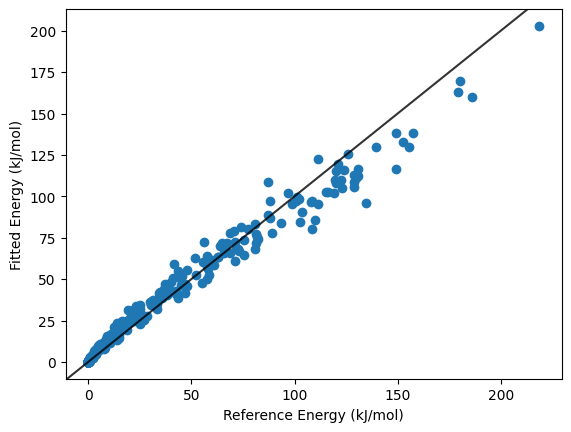

In [43]:
import matplotlib.pyplot as plt
plt.xlabel("Reference Energy (kJ/mol)")
plt.ylabel("Fitted Energy (kJ/mol)")
plt.axline((0, 0), slope=1, linewidth=1.5, color="k",alpha=0.8)
plt.scatter(energies_ref, energies)

## 4.使用DMFF进行液体碳酸二甲酯（DMC）的力场优化 <a id ='4'></a>
在下面的案例中，我们会给出DMFF的实际应用案例，并搭建相应的工作流

本案例主要由冯维贡献

### 4.1 介绍 <a id ='4-1'></a>
用DMFF搭建工作流的初始步骤是产生势函数，其流程和API与OpenMM类似，大致如下：

1. 首先定义力场对象（DMFF中称之为`Hamiltonian`），其中定义了原子归类（`typification`）规则以及所有的力场参数。大体上相当于表达为python对象的openmm的xml文件或是gromacs的itp文件。
2. 获取所需要模拟的体系的分子键连拓扑信息（通过pdb文件得到）。
3. 根据体系的连接拓扑，使用`Hamiltonian`对其中的每个原子、键长、键角、二面角等进行归类并参数化，创建势函数。势函数一般以原子位置、盒子大小、力场参数为输入，方便后续求导运算。
4. 如有必要，对势函数进行必要的修饰和拓展。例如，利用`jax.grad`得到力、维里矩阵的计算函数，可以直接用于MD模拟。
5. 也可以利用势函数定义相应性质的`estimator`和损失函数，并利用梯度下降优化器进行相应的参数优化。

**在DMFF中，我们提供了传统物理力场中PME、对相互作用、多极矩、可极化力场等势函数的JAX实现。利用JAX提供的修饰工具，用户可以对这些势函数进行微分，向量化、编译等修饰，也可以对其进行再封装和重组合以实现新的势函数，也可以基于这些势函数开发性质估计函数（`property estimators`），而这些新的函数也可以进一步被求导或者向量化。可以看出，这种以函数变换为核心的编程范式为DMFF中新力场、新目标函数的定义提供了无与伦比的灵活性。**

接下来，为了用户对DMFF中的主要模块和功能有个全面的认识，展示这些模块在力场开发中是如何互相配合的，我们通过碳酸二甲酯（DMC）的粗粒化模型，演示在DMFF中一个模型从定义、优化、到部署的全过程。任务的目标是：使用三个site表示DMC长链（以下称为3-site模型），如何优化这三个site间的相互作用，复现XRD实验测出的液体DMC的径向分布函数（Radial Distribution Function, RDF）并将DMC粗粒化模型力场与全原子模型OPLS-AA力场进行比对。

![s](https://i.postimg.cc/0QkqGSyz/pic.jpg)

下面进入工作文件夹

In [44]:
import os
current_directory = os.getcwd()  # 获取当前文件夹路径
parent_directory = os.path.dirname(current_directory)  # 获取上级文件夹路径
os.chdir(parent_directory)  # 切换到上级文件夹
os.chdir(os.path.join("DMC"))

### 4.2 定义势函数 <a id ='4-2'></a>
载入DMC体系的拓扑，并构建整个模拟盒子的势能函数：

In [45]:
from tqdm import tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

# define potentials
H = Hamiltonian("prm1.xml")
rc = 0.9
top_pdb = app.PDBFile("box_DMC.pdb")
pot = H.createPotential(top_pdb.topology, 
                        nonbondedMethod=app.PME, 
                        nonbondedCutoff=rc*unit.nanometer, 
                        useDispersionCorrection=False)
efunc = pot.getPotentialFunc()

In [46]:
params = H.getParameters()
print(params['NonbondedForce']['charge'])

[ 0.2841 -0.5682]


我们通过`prm.xml`力场文件文件可以看到，该势函数包含分子内原子间$bond$与$angle$的弹簧势、静电相互作用和分子间的$Lennard-Jones$势：

$$\begin{align*}
    V(\mathbf{R}) &= V_{\mathrm{bond}} + V_\mathrm{angle} + V_{\mathrm{elec}} + V_{\mathrm{vdW}} \\
    &=  \sum_{\mathrm{bonds}}k_r(r - r_0)^2 + \sum_{\mathrm{angles}}k_\theta(\theta - \theta_{eq})^2 + \sum_{\mathrm{i<j}}\frac{q_iq_j}{4\pi\epsilon_0r_{ij}}\\
    &\quad+ \sum_{ij}4\varepsilon_{ij}\left[\left(\frac{\sigma_{ij}}{r_{ij}}\right)^{12} - \left(\frac{\sigma_{ij}}{r_{ij}}\right)^6\right]
\end{align*}$$

而我们将优化其中的一些参数。

### 4.3 定义OpenMM采样器 <a id ='4-3'></a>

In [47]:
# OpenMM sampler, for resampling during optimization
def sample_with_prm(parameter, trajectory, init_struct="box_DMC.pdb"):
    pdb = app.PDBFile(init_struct)
    ff = app.ForceField(parameter)
    system = ff.createSystem(pdb.topology, 
                             nonbondedMethod=app.PME, 
                             nonbondedCutoff=rc*unit.nanometer, 
                             constraints=None)
    barostat = mm.MonteCarloBarostat(1.0*unit.bar, 293.0*unit.kelvin, 20)
    #barostat.setRandomNumberSeed(12345)
    system.addForce(barostat)
    for force in system.getForces():
        if isinstance(force, mm.NonbondedForce):
            force.setUseDispersionCorrection(False)
            force.setUseSwitchingFunction(False)
    integ = mm.LangevinIntegrator(293*unit.kelvin, 5/unit.picosecond, 1*unit.femtosecond)

    simulation = app.Simulation(pdb.topology, system, integ)
    simulation.reporters.append(app.DCDReporter(trajectory, 4000))
    simulation.reporters.append(app.StateDataReporter(sys.stdout, 20000, density=True, step=True, remainingTime=True, speed=True, totalSteps=500*1000))

    simulation.context.setPositions(pdb.getPositions())
    simulation.minimizeEnergy()
    simulation.step(500*1000)

该函数的功能，就在输入的`parameter`下，使用OpenMM生成NPT样本集，并存储在指定的`trajectory`文件中。后续优化需要重采样时我们会反复调用该函数。

### 4.4 初始MD采样 <a id ='4-4'></a>

In [48]:
# init sampling
sample_with_prm("prm1.xml", "init.dcd")

#"Step","Density (g/mL)","Speed (ns/day)","Time Remaining"
20000,0.6262534623308863,0,--
40000,0.5979051832690799,679,0:58
60000,0.6367384763452368,678,0:56
80000,0.6139587399937261,679,0:53
100000,0.6151387279860191,679,0:50
120000,0.5989298333138645,679,0:48
140000,0.6335292723148818,679,0:45
160000,0.6343532933548159,679,0:43
180000,0.6214166011781163,679,0:40
200000,0.6382065774390001,680,0:38
220000,0.6090503783169839,680,0:35
240000,0.6244315319426381,680,0:33
260000,0.613327148658729,680,0:30
280000,0.6114154616377299,680,0:27
300000,0.6164005785043938,680,0:25
320000,0.6360197331658057,680,0:22
340000,0.6158857376058046,680,0:20
360000,0.633164935263684,680,0:17
380000,0.6254281508591532,680,0:15
400000,0.6268376781117729,680,0:12
420000,0.6313746404948491,680,0:10
440000,0.6215903100117814,680,0:07
460000,0.6165084630785347,680,0:05
480000,0.6246335708795673,681,0:02
500000,0.6114394931719171,681,0:00


### 4.5 定义性质计算函数 <a id ='4-5'></a>

在接下来的拟合中我们需要同时拟合RDF和密度，因此我们分别定义RDF和密度的计算函数：

In [49]:
# define property calculator, in our case, rdf for each frame:
def compute_rdf_frame(traj, xaxis):
    rdf_list = []
    delta = xaxis[1] - xaxis[0]

    coordinates = traj.xyz
    masses = np.array([15, 15, 60])  # 每个site的质量
    coordinates_3d = coordinates.reshape((traj.n_frames, 175, 3, 3))
    com = np.sum(masses[:, np.newaxis] * coordinates_3d, axis=2) / 90

    pairs = np.array(list(combinations(range(175), 2)))

    tidx = np.arange(0, 525, 3, dtype=int)
    tsub = traj.atom_slice(tidx)
    tsub.xyz = com
    
    for frame in tsub:
        _, g_r = md.compute_rdf(frame, pairs, r_range=(xaxis[0]-0.5*delta, xaxis[-1]+0.5*delta+1e-10), bin_width=delta)
        rdf_list.append(g_r.reshape((1, -1)))
    return np.concatenate(rdf_list, axis=0)


def compute_den_frame(traj):
    vols = traj.unitcell_volumes      # angstrom
    return 26.1627907 / vols  # convert to g/mL

在计算观测量$A$的系综平均时，需要计算如下统计量： $\langle A \rangle_p = \sum_n W (x_n ; \theta) A(x_n ; \theta)$，以上代码就定义了 $A(x_n ; \theta)$ 函数。
一般来说，我们需要把 $\langle A \rangle_p $ 封装在一个函数里面，然后在每一轮优化时对其整体进行求导。
但在这里，因为RDF和密度都是纯粹的结构性质，和 $\theta$ 无关也不参与求导，因此我们可以将每个样本的RDF （ $A(x_n)$ ）算好并预存，没有必要每一轮都重复计算。
在上示代码中，我们也完全采用`mdtraj`中的现成工具计算每一帧的RDF，而不必采用可微分的jax实现。

### 4.6 读入数据并进行比对 <a id ='4-6'></a>

读入实验数据，并使用上面定义的性质计算函数，预先计算出DMC全原子模型在OPLS-AA力场下的RDF，作为比对（OPLS-AA力场参数由LigPargen生成）：

In [50]:
# Prepare reference data
def readRDF(fname):
    with open(fname, "r") as f:
        data = np.array([[float(j) for j in i.strip().split()] for i in f])
    xaxis = np.linspace(2.0, 14.0, 121)
    yinterp = np.interp(xaxis, data[:,0], data[:,1])
    return xaxis, yinterp

# read experimental benzene RDF
x_ref, y_ref = readRDF("DMC_Experi.txt")
m_ref, n_ref = readRDF("DMC_OPLS.txt")

我们将RDF计算函数得到的粗粒化模型结果与实验数据及全原子模型在OPLS-AA力场下的结果进行比对。可以先看一下由初始参数采样形成的RDF，这也是我们优化的起点：

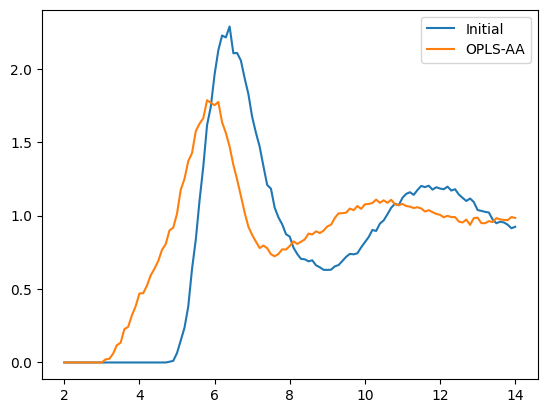

In [51]:
traj_init = md.load("init.dcd", top="box_DMC.pdb")[50:]
rdf_frames_init = compute_rdf_frame(traj_init, x_ref*0.1)
rdf_init = rdf_frames_init.mean(axis=0)

plt.plot(x_ref, rdf_init, label = "Initial")
#plt.plot(x_ref, y_ref, label = "Experiment")
plt.plot(m_ref, n_ref, label = "OPLS-AA")

plt.legend()
plt.show()

到这里，我们完成了力场优化的准备工作。在进行优化循环之前，需要准备几个工具，这里我们引入DMFF **0.2.0**版本的特色功能——Property Estimator

分子动力学模拟中跨越整条轨迹的深度计算图在时间与计算代价上都是巨大的。而这一缺憾可以通过轨迹重新加权的方案来避免。在DMFF中，重加权算法被引入MBAR方法中，并拓展了平均性质与自由能的可微分估计量:

![s](https://i.postimg.cc/v8VbtcQH/Traj-reweighting.jpg)

在参数优化的梯度下降训练中，参数在每个训练周期只受到轻微扰动，因此可以继续使用前一周期的采样，以至于在优化系综未显著偏离采样系综前都不需要重采样，这大幅降低了优化的时间与计算成本。在重加权MBAR Estimator中，我们定义两种系综：采样系综，从中提取所有样本；目标系综，即需要优化的系综。采样系综只在必要时更新，且不需要可微分，其数据可以由外部采样器如OpenMM生成。我们通过Estimator给出权重因子，以采样系综中样本的加权平均作为目标系综的估计。这一工作流程可以通过下面的流程图理解：

![s](https://i.postimg.cc/1XQmqQVK/opt-baseline.jpg)

其中**Effective Sample Size**即对采样系综偏离目标系综程度的描述。当偏离过大时，采样系综进行更新。

### 4.7 Estimator 初始化 <a id ='4-7'></a>

In [52]:
# Initialize estimator
estimator = MBAREstimator()
# prepare sampling state and samples
state_name = "prm"
state = OpenMMSampleState(state_name, "prm1.xml", "box_DMC.pdb", temperature=293.0, pressure=1.0)
traj = md.load("init.dcd", top="box_DMC.pdb")[50:]
sample = Sample(traj, state_name)
# add sample and the state to the estimator
estimator.add_state(state)
estimator.add_sample(sample)
estimator.optimize_mbar()

这里，我们创建`MBAREstimator`，并对其进行初始化。`MBAREstimator`中需要初始化的变量包括两部分：

+ 其包含的所有采样态信息（`state`）、样本$x_n$（`sample`） ； 
+ 根据样本和采样态信息估计得到的采样态配分函数 ( $\hat{f}_m $)

可以看出，在上述代码中，我们定义了一个`OpenMMSampleState`，并将该`state`和由该`state`采样产生的样本添加到了`estimator`中，并调用`optimize_mbar`函数（该函数会在后台调用外部的`pymbar`工具）对其中所有采样态的配分函数进行估计。注意这些操作都不参与微分，也不依赖jax。完成初始化后的`estimator`就可以以可微分的方式直接给出$ W(x_n)$了。

### 4.8 定义目标系综 <a id ='4-8'></a>

In [53]:
# Prepare the target state
cov_map = pot.meta['cov_map']
# Define effective energy function
target_energy_function = buildTrajEnergyFunction(efunc, cov_map, rc, ensemble='npt', pressure=1.0)
target_state = TargetState(293.0, target_energy_function)

在这里，我们通过之前已经定义好的可微分3-site模型势函数`efunc`定义了我们的目标系综`target_state`。作为后续`reweighting`的输入参数。后续`estimator`在计算时会反复调用`target_state`中的`efunc`去计算样本在目标系综中的有效能量（对NVT系综为$ u = U(x_n)$ ，对NPT系综则为 $u = U(x_n) - pV$ ）。

### 4.9 定义损失函数 <a id ='4-9'></a>

In [54]:
# Define loss function
rdf_frames = compute_rdf_frame(estimator._full_samples, x_ref*0.1)
den_frames = compute_den_frame(estimator._full_samples)

def neutralize(param):
    net_q = jnp.dot(params['NonbondedForce']['charge'], jnp.array([2.0, 1.0]))
    param['NonbondedForce']['charge'] = param['NonbondedForce']['charge'] - net_q / 3.0
    return param

def lossfunc(param):
    # neutralize charge
    param = neutralize(param)
    weight, utarget = estimator.estimate_weight(target_state, parameters=param)
    rdf_pert = (rdf_frames * weight.reshape((-1, 1))).sum(axis=0)
    loss_ref = jnp.log(jnp.power(rdf_pert - n_ref, 2).mean())
    
    # loss function of density 
    den = (den_frames * weight).sum()
    loss_den = (den - 1.07)**2 * 10.0
    
    return loss_ref + loss_den, utarget

def lossfunc_den(param):
    # neutralize charge
    param = neutralize(param)
    weight, utarget = estimator.estimate_weight(target_state, parameters=param)
    # loss function of density 
    den = (den_frames * weight).sum()
    loss_den = (den - 1.07)**2 * 20.0
    
    return loss_den, utarget

这里，我们通过`estimator.estimate_weight`函数生成当前`target_state`所对应的$W(x_n; \theta_p)$，进而给出当前`target_state`下的RDF平均值，与实验参考值比较得到RDF目标函数：

$L_{\text{RDF}} =  \text{log} \Vert \sum_{n=1}^N W_n \boldsymbol{v}_n - \boldsymbol{v}_{\text{ref}} \Vert$

同时我们发现，如果单纯优化RDF，优化器容易探索到非物理的参数区域，导致体系密度降低、直至跨越相边界成为气体。为避免这一现象，我们在损失函数中也加入了密度误差，以求对体系的密度进行控制。因此我们也单独定义了密度的损失函数：

$L_{\rho} = \left(\sum_{n=1}^N {W_n \rho_n} - \rho_{\text{ref}}\right)^2 $

在下面的优化循环中我们将首先针对密度进行几轮优化，然后再开始对RDF的调优。

### 4.10 优化器准备及优化循环 <a id ='4-10'></a>

In [55]:
# Prepare optimizer
multiTrans = MultiTransform(H.paramtree)
multiTrans["NonbondedForce/sigma"] = genOptimizer(learning_rate=0.005, clip=0.05)
multiTrans["NonbondedForce/epsilon"] = genOptimizer(learning_rate=0.005, clip=0.05)
multiTrans["NonbondedForce/charge"] = genOptimizer(learning_rate=0.001, clip=0.05)
# multiTrans["HarmonicBondForce/k"] = genOptimizer(learning_rate=10.0, clip=10.0)
#multiTrans["HarmonicAngleForce/k"] = genOptimizer(learning_rate=5.0, clip=1.0)
multiTrans.finalize()
grad_transform = optax.multi_transform(multiTrans.transforms, multiTrans.labels)
mask = jax.tree_util.tree_map(lambda x: x.dtype != jnp.int32 and x.dtype != int, params)
grad_transform = optax.masked(grad_transform, mask)
opt_state = grad_transform.init(H.paramtree)

LOOP 1
Loss: 0.2240529
Effective sample sizes:
prm: 73
Total: 74.88173777019114
LOOP 2
Loss: 0.097934246
Effective sample sizes:
prm: 1
Total: 1.272279194934353
Add loop-2
#"Step","Density (g/mL)","Speed (ns/day)","Time Remaining"
20000,0.6208444221431734,0,--
40000,0.6443527171889122,670,0:59
60000,0.6397980218730572,670,0:56
80000,0.659087579523581,670,0:54
100000,0.6317739762177391,670,0:51
120000,0.6470080007283606,670,0:48
140000,0.6186115769648355,670,0:46
160000,0.6575095953996037,670,0:43
180000,0.6551322443043226,670,0:41
200000,0.633670902079612,670,0:38
220000,0.6195185122701818,670,0:36
240000,0.6552426406703384,670,0:33
260000,0.6630423288344892,670,0:30
280000,0.6446457576944415,670,0:28
300000,0.642648188532025,670,0:25
320000,0.642981635441399,670,0:23
340000,0.6392274427761977,670,0:20
360000,0.6389745743132177,670,0:18
380000,0.6431079280146335,670,0:15
400000,0.6508260581227254,670,0:12
420000,0.6516385560804312,670,0:10
440000,0.6287277393408163,670,0:07
460000,0.64

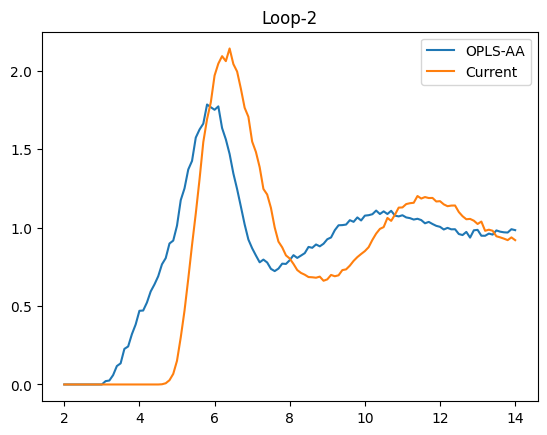

LOOP 3
Loss: -0.2069664
Effective sample sizes:
loop-2: 73
Total: 74.99996890898849
LOOP 4
Loss: -0.34761918
Effective sample sizes:
loop-2: 5
Total: 6.614635511250354
Add loop-4
#"Step","Density (g/mL)","Speed (ns/day)","Time Remaining"
20000,0.6710663749825658,0,--
40000,0.6668877784214613,681,0:58
60000,0.6902330706633126,682,0:55
80000,0.6694835172096921,682,0:53
100000,0.6659591474301739,682,0:50
120000,0.695745958474436,682,0:48
140000,0.6753367501178502,682,0:45
160000,0.6647706539928707,682,0:43
180000,0.6625374910610655,682,0:40
200000,0.6542075804087728,682,0:37
220000,0.6910639327722591,682,0:35
240000,0.6796278714976502,682,0:32
260000,0.6842488508578194,682,0:30
280000,0.6586018675319847,682,0:27
300000,0.6792290074192513,682,0:25
320000,0.6908791918277292,682,0:22
340000,0.6846782053171957,682,0:20
360000,0.6588514824323279,682,0:17
380000,0.6713388326965002,682,0:15
400000,0.674826672608335,682,0:12
420000,0.6708402688194245,682,0:10
440000,0.6796461740302306,682,0:07
46

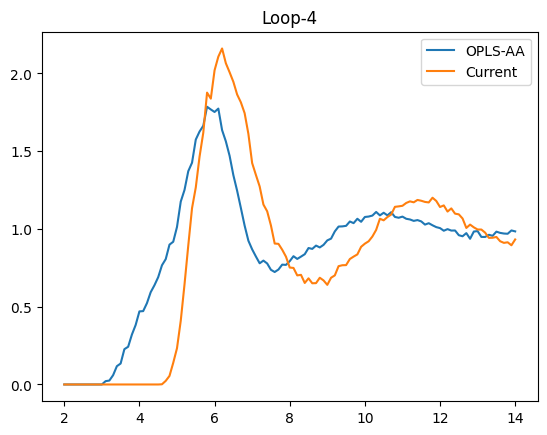

LOOP 5
Loss: -0.7002218
Effective sample sizes:
loop-4: 73
Total: 74.99999914289698
LOOP 6
Loss: -0.87519896
Effective sample sizes:
loop-4: 5
Total: 5.377502732697501
Add loop-6
#"Step","Density (g/mL)","Speed (ns/day)","Time Remaining"
20000,0.7222577929948555,0,--
40000,0.7122842623600855,679,0:58
60000,0.7249569812083735,680,0:55
80000,0.7015140664137675,679,0:53
100000,0.7092198435968261,679,0:50
120000,0.7251277246085257,679,0:48
140000,0.7086264789808532,679,0:45
160000,0.7245344243211415,679,0:43
180000,0.7096190082561249,679,0:40
200000,0.7088526855722939,679,0:38
220000,0.7032134170638353,679,0:35
240000,0.7181539714452446,679,0:33
260000,0.6989360484365197,679,0:30
280000,0.7196247533358019,679,0:28
300000,0.7113985877816236,679,0:25
320000,0.718765248605541,679,0:22
340000,0.7122563087041722,679,0:20
360000,0.7126618066373461,679,0:17
380000,0.7038080532685532,679,0:15
400000,0.67838870942888,679,0:12
420000,0.7073927549432679,680,0:10
440000,0.6935848705432649,679,0:07
460

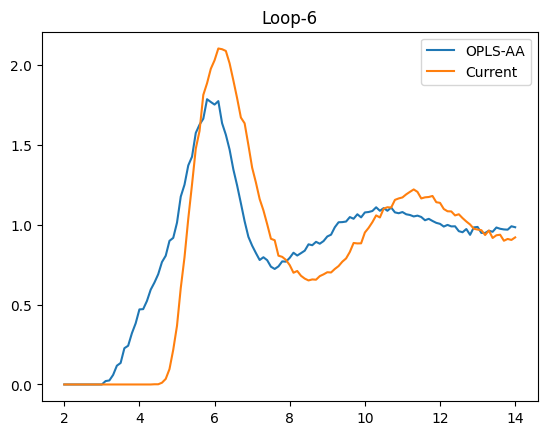

LOOP 7
Loss: -1.1525846
Effective sample sizes:
loop-6: 73
Total: 74.99999885757484
LOOP 8
Loss: -1.280098
Effective sample sizes:
loop-6: 7
Total: 7.4077761976938215
Add loop-8
#"Step","Density (g/mL)","Speed (ns/day)","Time Remaining"
20000,0.7430683072347857,0,--
40000,0.7456991368323435,1.24e+03,0:32
60000,0.7178189972289448,1.24e+03,0:30
80000,0.7587269323853197,1.24e+03,0:29
100000,0.7138115758172238,1.23e+03,0:28
120000,0.7675447932337025,1.22e+03,0:26
140000,0.7196868748929646,1.22e+03,0:25
160000,0.7183551404397897,1.22e+03,0:24
180000,0.737535045112988,1.22e+03,0:22
200000,0.7371674032108128,1.21e+03,0:21
220000,0.7425750354913524,1.21e+03,0:19
240000,0.7482717951960083,1.21e+03,0:18
260000,0.752026312593297,1.21e+03,0:17
280000,0.7491459218049741,1.21e+03,0:15
300000,0.7580683791346564,1.21e+03,0:14
320000,0.7186658588923605,1.21e+03,0:12
340000,0.7405926483730926,1.21e+03,0:11
360000,0.7070759029052557,1.21e+03,0:10
380000,0.7373552583142811,1.21e+03,0:08
400000,0.754577108

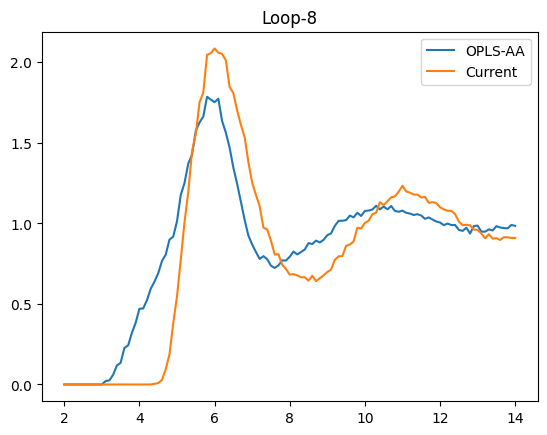

LOOP 9
Loss: -1.6445246
Effective sample sizes:
loop-8: 73
Total: 74.9999989866962
LOOP 10
Loss: -1.729428
Effective sample sizes:
loop-8: 7
Total: 7.236897829405265
Add loop-10
#"Step","Density (g/mL)","Speed (ns/day)","Time Remaining"
20000,0.7862723513746704,0,--
40000,0.7648712420843758,1.25e+03,0:31
60000,0.7492999104472768,1.25e+03,0:30
80000,0.7653726290984872,1.25e+03,0:29
100000,0.7792141444788738,1.25e+03,0:27
120000,0.775267702918354,1.25e+03,0:26
140000,0.7628401944518938,1.25e+03,0:24
160000,0.7726932771850299,1.25e+03,0:23
180000,0.7570253527781643,1.25e+03,0:22
200000,0.767336297089223,1.25e+03,0:20
220000,0.7863518276866206,1.25e+03,0:19
240000,0.7861120314565686,1.25e+03,0:18
260000,0.787858117129792,1.25e+03,0:16
280000,0.7763311981483464,1.25e+03,0:15
300000,0.7778355625970119,1.25e+03,0:13
320000,0.7571765346887934,1.25e+03,0:12
340000,0.7789380963974676,1.25e+03,0:11
360000,0.7676079033003674,1.25e+03,0:09
380000,0.7588960438118437,1.25e+03,0:08
400000,0.7718529943

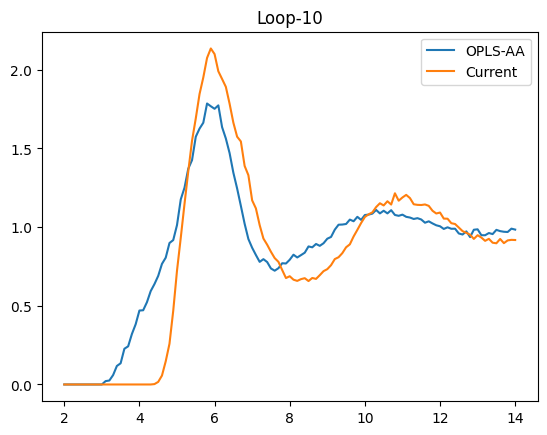

LOOP 11
Loss: -2.0257616
Effective sample sizes:
loop-10: 73
Total: 74.99948686768502
LOOP 12
Loss: -2.0836902
Effective sample sizes:
loop-10: 10
Total: 10.197496204418968
Add loop-12
#"Step","Density (g/mL)","Speed (ns/day)","Time Remaining"
20000,0.79334067063448,0,--
40000,0.804414750909207,1.2e+03,0:33
60000,0.8118520453396658,1.2e+03,0:31
80000,0.8065963106824426,1.2e+03,0:30
100000,0.815522183846582,1.2e+03,0:28
120000,0.8256805255164391,1.2e+03,0:27
140000,0.8199839979450168,1.2e+03,0:25
160000,0.809446926235706,1.2e+03,0:24
180000,0.8008621860241973,1.2e+03,0:23
200000,0.8076745414916476,1.2e+03,0:21
220000,0.763395660578042,1.2e+03,0:20
240000,0.8090271105328266,1.2e+03,0:18
260000,0.8138340705371971,1.2e+03,0:17
280000,0.7900378152404358,1.2e+03,0:15
300000,0.7880035935299785,1.2e+03,0:14
320000,0.7983866776512757,1.2e+03,0:12
340000,0.7822455919133926,1.2e+03,0:11
360000,0.7944095916801724,1.2e+03,0:10
380000,0.8020814071232497,1.2e+03,0:08
400000,0.7731138252057901,1.2e+03

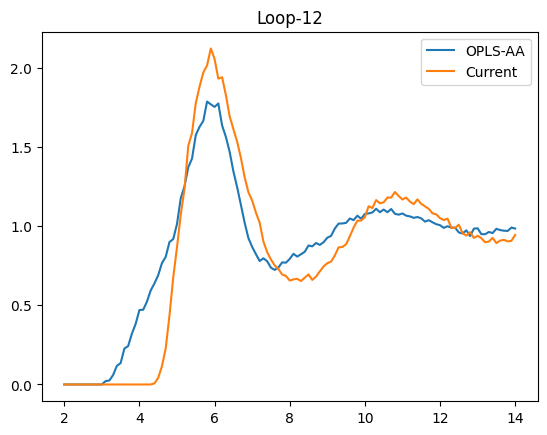

LOOP 13
Loss: -2.381125
Effective sample sizes:
loop-12: 73
Total: 74.99955104529661
LOOP 14
Loss: -2.4575481
Effective sample sizes:
loop-12: 21
Total: 21.744361014850465
LOOP 15
Loss: -2.4513159
Effective sample sizes:
loop-12: 8
Total: 8.3375742507131
Add loop-15
#"Step","Density (g/mL)","Speed (ns/day)","Time Remaining"
20000,0.8492333341729849,0,--
40000,0.8569745173703381,1.21e+03,0:32
60000,0.8436699822674257,1.21e+03,0:31
80000,0.810778140982722,1.21e+03,0:29
100000,0.8502076985948657,1.22e+03,0:28
120000,0.8582873082275689,1.22e+03,0:26
140000,0.8517274568848869,1.22e+03,0:25
160000,0.857220244471228,1.23e+03,0:23
180000,0.8274786536228007,1.23e+03,0:22
200000,0.8489682465216621,1.23e+03,0:21
220000,0.8488527095764091,1.23e+03,0:19
240000,0.8361623549495133,1.23e+03,0:18
260000,0.831990479513602,1.23e+03,0:16
280000,0.8459975715332729,1.23e+03,0:15
300000,0.8182259079604962,1.23e+03,0:14
320000,0.8547918433887624,1.23e+03,0:12
340000,0.8581096809175794,1.23e+03,0:11
360000,0.8

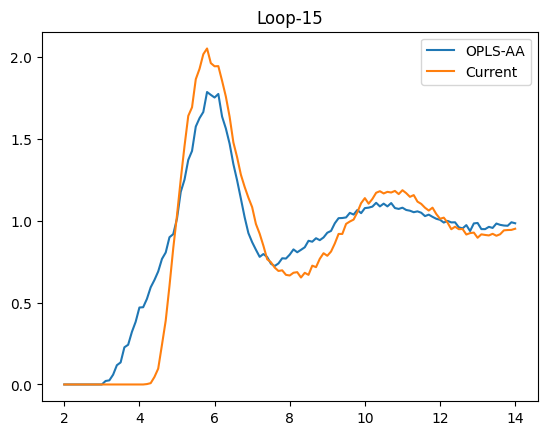

LOOP 16
Loss: -2.8382268
Effective sample sizes:
loop-15: 73
Total: 74.99999924494927
LOOP 17
Loss: -2.8543139
Effective sample sizes:
loop-15: 10
Total: 10.734610137587874
Add loop-17
#"Step","Density (g/mL)","Speed (ns/day)","Time Remaining"
20000,0.875030558979413,0,--
40000,0.8581164348371972,1.24e+03,0:31
60000,0.8838279793744921,1.23e+03,0:31
80000,0.8680760162599586,1.22e+03,0:29
100000,0.8744979520355435,1.22e+03,0:28
120000,0.8771989690445915,1.21e+03,0:27
140000,0.855702378528945,1.21e+03,0:25
160000,0.844948249872342,1.21e+03,0:24
180000,0.872474838379736,1.21e+03,0:22
200000,0.8714566357317904,1.21e+03,0:21
220000,0.8788150848143107,1.21e+03,0:20
240000,0.8367059900691103,1.21e+03,0:18
260000,0.8471670711732167,1.21e+03,0:17
280000,0.8611705552645426,1.21e+03,0:15
300000,0.9104478682027041,1.21e+03,0:14
320000,0.8753725764455916,1.21e+03,0:12
340000,0.8447627426575864,1.21e+03,0:11
360000,0.864783090273323,1.21e+03,0:10
380000,0.8364664418128258,1.21e+03,0:08
400000,0.87584

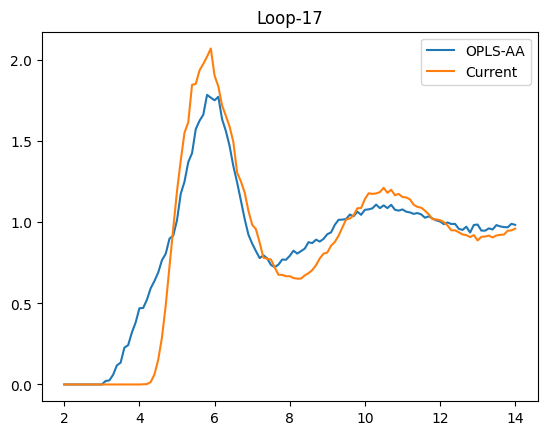

LOOP 18
Loss: -3.0364313
Effective sample sizes:
loop-17: 73
Total: 74.99966213782898
LOOP 19
Loss: -3.1017027
Effective sample sizes:
loop-17: 12
Total: 12.838946388547594
Add loop-19
#"Step","Density (g/mL)","Speed (ns/day)","Time Remaining"
20000,0.8937080304967736,0,--
40000,0.8740066959584428,1.22e+03,0:32
60000,0.9006905741392564,1.23e+03,0:30
80000,0.9009332892015642,1.24e+03,0:29
100000,0.8682032231342941,1.24e+03,0:27
120000,0.8944060587186294,1.23e+03,0:26
140000,0.8905101682615891,1.23e+03,0:25
160000,0.8923340832558888,1.23e+03,0:23
180000,0.9450236906725115,1.23e+03,0:22
200000,0.887364226143676,1.23e+03,0:21
220000,0.8607137881521087,1.23e+03,0:19
240000,0.8568324246320029,1.22e+03,0:18
260000,0.8880106096872632,1.22e+03,0:16
280000,0.873312581241122,1.22e+03,0:15
300000,0.9020696200954927,1.23e+03,0:14
320000,0.8991655486147812,1.23e+03,0:12
340000,0.8663418900265081,1.23e+03,0:11
360000,0.8623577765225361,1.23e+03,0:09
380000,0.8968516280340029,1.23e+03,0:08
400000,0.87

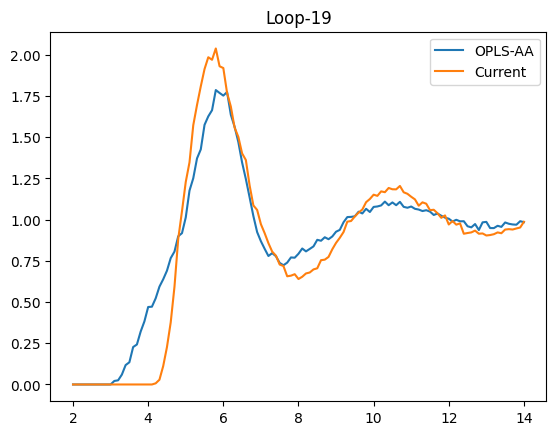

LOOP 20
Loss: -3.223215
Effective sample sizes:
loop-19: 73
Total: 74.99999929747894
LOOP 21
Loss: -3.252371
Effective sample sizes:
loop-19: 13
Total: 13.293670556651799
Add loop-21
#"Step","Density (g/mL)","Speed (ns/day)","Time Remaining"
20000,0.9092523858753648,0,--
40000,0.9338200039853676,1.21e+03,0:32
60000,0.9136871431416292,1.21e+03,0:31
80000,0.911524361452913,1.2e+03,0:30
100000,0.8906940845947352,1.2e+03,0:28
120000,0.8872936891941104,1.2e+03,0:27
140000,0.8858859911271065,1.2e+03,0:25
160000,0.9285665186274764,1.2e+03,0:24
180000,0.8985496418766948,1.2e+03,0:22
200000,0.895695863172435,1.2e+03,0:21
220000,0.9009048232244116,1.2e+03,0:20
240000,0.9074997766926701,1.2e+03,0:18
260000,0.9250688073199057,1.2e+03,0:17
280000,0.9031815824517371,1.2e+03,0:15
300000,0.9233125460626286,1.2e+03,0:14
320000,0.9079136664842743,1.2e+03,0:12
340000,0.9210012902959677,1.2e+03,0:11
360000,0.8897419405470277,1.2e+03,0:10
380000,0.9194527594859692,1.2e+03,0:08
400000,0.8940382429375971,1.2

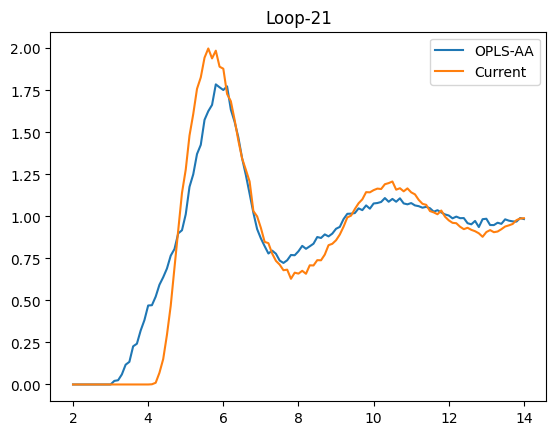

LOOP 22
Loss: -3.3364758
Effective sample sizes:
loop-21: 73
Total: 74.99969728353418
LOOP 23
Loss: -3.357068
Effective sample sizes:
loop-21: 42
Total: 42.096113249116385
LOOP 24
Loss: -3.3720813
Effective sample sizes:
loop-21: 23
Total: 23.4039264193694
LOOP 25
Loss: -3.3839772
Effective sample sizes:
loop-21: 16
Total: 16.03992227481135
LOOP 26
Loss: -3.3901343
Effective sample sizes:
loop-21: 12
Total: 12.736622308487476
Add loop-26
#"Step","Density (g/mL)","Speed (ns/day)","Time Remaining"
20000,0.9124703794522817,0,--
40000,0.9062771212153529,1.24e+03,0:32
60000,0.8913718367932925,1.24e+03,0:30
80000,0.9094440433609966,1.24e+03,0:29
100000,0.9326982526479309,1.24e+03,0:27
120000,0.9424668958099008,1.25e+03,0:26
140000,0.9242438012062746,1.25e+03,0:24
160000,0.9142032864294835,1.25e+03,0:23
180000,0.9424513162472102,1.25e+03,0:22
200000,0.9324420399613884,1.25e+03,0:20
220000,0.9456051707851126,1.25e+03,0:19
240000,0.9187883463801549,1.25e+03,0:18
260000,0.9084682766732673,1.25e+

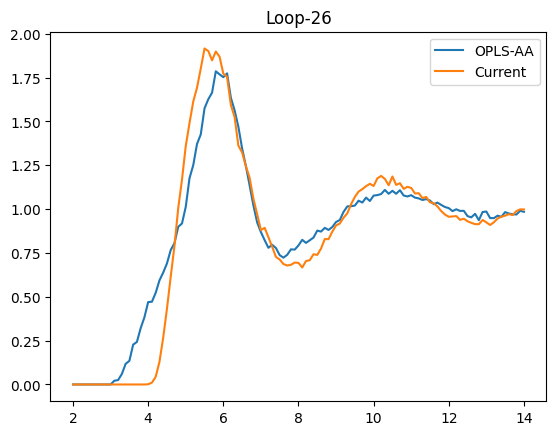

LOOP 27
Loss: -3.5866797
Effective sample sizes:
loop-26: 74
Total: 74.99999913655313
LOOP 28
Loss: -3.6368806
Effective sample sizes:
loop-26: 57
Total: 57.50504382295277
LOOP 29
Loss: -3.6678083
Effective sample sizes:
loop-26: 31
Total: 31.009312128594008
LOOP 30
Loss: -3.6723044
Effective sample sizes:
loop-26: 19
Total: 19.097134829440076
LOOP 31
Loss: -3.6621037
Effective sample sizes:
loop-26: 14
Total: 14.309990486582029
Add loop-31
#"Step","Density (g/mL)","Speed (ns/day)","Time Remaining"
20000,0.9298089890200912,0,--
40000,0.9143231647824057,1.21e+03,0:32
60000,0.9030197290791521,1.21e+03,0:31
80000,0.924583307598161,1.21e+03,0:30
100000,0.9283256720094367,1.21e+03,0:28
120000,0.9040032287017192,1.22e+03,0:26
140000,0.9404629922485397,1.22e+03,0:25
160000,0.9265826188202676,1.22e+03,0:24
180000,0.9173791482219718,1.23e+03,0:22
200000,0.9020964348258156,1.23e+03,0:21
220000,0.8827257399778715,1.23e+03,0:19
240000,0.9080367511307808,1.23e+03,0:18
260000,0.9374097093693218,1.23

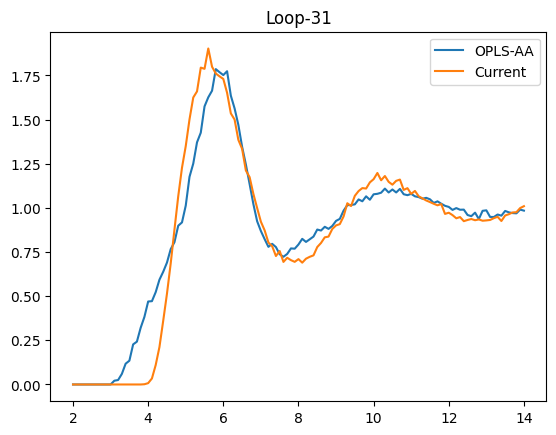

LOOP 32
Loss: -3.7287264
Effective sample sizes:
loop-31: 73
Total: 74.99999902365938
LOOP 33
Loss: -3.7797463
Effective sample sizes:
loop-31: 51
Total: 52.70028823559373
LOOP 34
Loss: -3.7864347
Effective sample sizes:
loop-31: 14
Total: 14.965259877824433
Add loop-34
#"Step","Density (g/mL)","Speed (ns/day)","Time Remaining"
20000,0.9500238650214056,0,--
40000,0.8930424230472622,1.21e+03,0:32
60000,0.931426574698688,1.21e+03,0:31
80000,0.9264064841788014,1.22e+03,0:29
100000,0.9312271897044995,1.23e+03,0:28
120000,0.9523005857460182,1.23e+03,0:26
140000,0.9263704399256429,1.24e+03,0:25
160000,0.9217103259921352,1.24e+03,0:23
180000,0.895274992954293,1.24e+03,0:22
200000,0.936120925789809,1.24e+03,0:20
220000,0.9390943450597724,1.24e+03,0:19
240000,0.93636237492432,1.23e+03,0:18
260000,0.9140215345857565,1.23e+03,0:16
280000,0.9257994481028843,1.23e+03,0:15
300000,0.8953588094880908,1.23e+03,0:14
320000,0.9126024317817006,1.23e+03,0:12
340000,0.9120423697630627,1.23e+03,0:11
360000,0

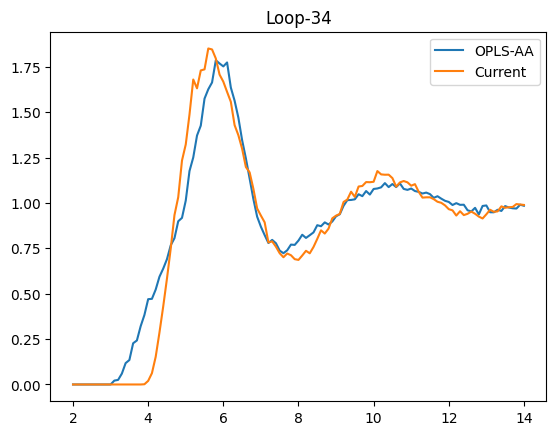

LOOP 35
Loss: -3.864217
Effective sample sizes:
loop-34: 73
Total: 74.99999922989284
LOOP 36
Loss: -3.8884299
Effective sample sizes:
loop-34: 66
Total: 67.68063828747535
LOOP 37
Loss: -3.9015973
Effective sample sizes:
loop-34: 50
Total: 51.828234294620096
LOOP 38
Loss: -3.9042518
Effective sample sizes:
loop-34: 37
Total: 37.25293779548711
LOOP 39
Loss: -3.9009047
Effective sample sizes:
loop-34: 27
Total: 27.367122431104555
LOOP 40
Loss: -3.889514
Effective sample sizes:
loop-34: 20
Total: 20.032431290055047
LOOP 41
Loss: -3.8824654
Effective sample sizes:
loop-34: 17
Total: 17.428508080701874
LOOP 42
Loss: -3.87871
Effective sample sizes:
loop-34: 16
Total: 16.00296105402969
LOOP 43
Loss: -3.8744707
Effective sample sizes:
loop-34: 15
Total: 15.130586225733753
LOOP 44
Loss: -3.873681
Effective sample sizes:
loop-34: 15
Total: 15.016419982277405
LOOP 45
Loss: -3.8914013
Effective sample sizes:
loop-34: 18
Total: 18.741683172419176
LOOP 46
Loss: -3.8920405
Effective sample sizes:
loo

In [56]:
loss_list = []
traj_init = md.load("init.dcd", top="box_DMC.pdb")[50:]
rdf_frames_init = compute_rdf_frame(traj_init, x_ref*0.1)
rdf_init = rdf_frames_init.mean(axis=0)

# Total number of loops
NL = 60
# Number of density loops
NL_den = 0

for nloop in range(1, NL+1):
    print("LOOP", nloop)
    if nloop <= NL_den:
        (loss, utarget), g = jax.value_and_grad(lossfunc_den, 0, has_aux=True, allow_int=True)(H.paramtree)
    else:
        (loss, utarget), g = jax.value_and_grad(lossfunc, 0, has_aux=True, allow_int=True)(H.paramtree)
        
    loss_list.append(loss)
    print("Loss:", loss)
    sys.stdout.flush()
    # evaluate effective sample size
    ieff = estimator.estimate_effective_sample(utarget, decompose=True)

    # update parameter use optax adam optimizer
    updates, opt_state = grad_transform.update(g, opt_state, params=H.paramtree)
    # deal with integer updates
    updates['NonbondedForce']['vsite_types'] = np.array([], dtype=jnp.int32)
    newprm = optax.apply_updates(H.paramtree, updates)
    H.updateParameters(newprm)

    # print out the updated parameter, save it in a xml
    H.paramtree = neutralize(H.paramtree)
    H.render(f"loop-{nloop}.xml")

    # checkout the effective size of each sample in the estimator
    print("Effective sample sizes:")
    for k, v in ieff.items():
        print(f"{k}: {v}")

    # remove all state with a sample size smaller than 5
    for k, v in ieff.items():
        if v < 15 and k != "Total":
            estimator.remove_state(k)
    
    # if all the states are removed, add a new state.
    if len(estimator.states) < 1:
        print("Add", f"loop-{nloop}")
        # get new sample using the current state
        sample_with_prm(f"loop-{nloop}.xml", f"loop-{nloop}.dcd")
        traj = md.load(f"loop-{nloop}.dcd", top="box_DMC.pdb")[50:]
        state = OpenMMSampleState(f"loop-{nloop}", f"loop-{nloop}.xml", "box_DMC.pdb", temperature=293.0, pressure=1.0)
        sample = Sample(traj, f"loop-{nloop}")
        estimator.add_state(state)
        estimator.add_sample(sample)
        
        # estimator need to be reconverged whenenver new samples or states are added
        estimator.optimize_mbar()
        # property of each sample need to be updated as well
        rdf_frames = compute_rdf_frame(estimator._full_samples, x_ref*0.1)
        den_frames = compute_den_frame(estimator._full_samples)
    
        rdf_frames = compute_rdf_frame(traj, x_ref*0.1)
        plt.plot(m_ref, n_ref, label = "OPLS-AA")
        # plt.plot(x_ref, y_ref, label = "Experiment")
        plt.plot(x_ref, rdf_frames.mean(axis=0), label = "Current")
        plt.legend()
        plt.title(f"Loop-{nloop}")
        # plt.savefig("compare.png")
        plt.show()

#"Step","Density (g/mL)","Speed (ns/day)","Time Remaining"
20000,0.9034204023148491,0,--
40000,0.9134589209326665,1.21e+03,0:32
60000,0.9311857845324879,1.21e+03,0:31
80000,0.9209480174841933,1.21e+03,0:30
100000,0.9036050529338874,1.21e+03,0:28
120000,0.9120823292515017,1.21e+03,0:27
140000,0.9411380111912142,1.21e+03,0:25
160000,0.9263761966211715,1.21e+03,0:24
180000,0.9349105015898002,1.21e+03,0:22
200000,0.9028592257494273,1.21e+03,0:21
220000,0.9397294615775963,1.21e+03,0:20
240000,0.916016085063393,1.21e+03,0:18
260000,0.9369981516116607,1.21e+03,0:17
280000,0.911334635669278,1.21e+03,0:15
300000,0.9169613328351074,1.21e+03,0:14
320000,0.9107559836942581,1.21e+03,0:12
340000,0.9008690012597967,1.21e+03,0:11
360000,0.9255158510125162,1.21e+03,0:10
380000,0.9173521261898001,1.21e+03,0:08
400000,0.9199973033288819,1.21e+03,0:07
420000,0.9071096082489485,1.21e+03,0:05
440000,0.9137287359774533,1.21e+03,0:04
460000,0.8926880220808483,1.21e+03,0:02
480000,0.9341117246446181,1.21e+03,0

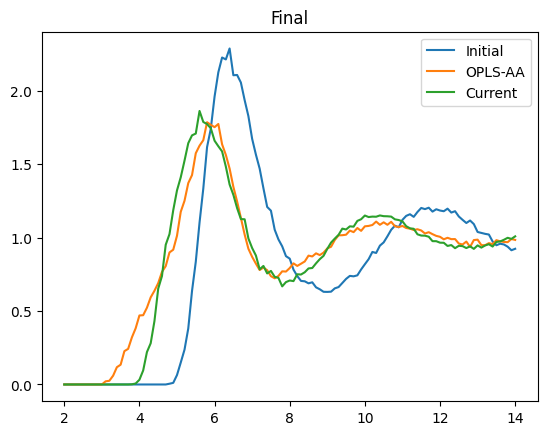

In [57]:
sample_with_prm(f"loop-{NL}.xml", f"loop-{NL}.dcd")
traj = md.load(f"loop-{NL}.dcd", top="box_DMC.pdb")[50:]
rdf_final = compute_rdf_frame(traj, x_ref*0.1).mean(axis=0)

plt.plot(x_ref, rdf_init, label = "Initial")
plt.plot(m_ref, n_ref, label = "OPLS-AA")
#plt.plot(x_ref, y_ref, label = "Experiment")
plt.plot(x_ref, rdf_final, label = "Current")
plt.legend()
plt.title(f"Final")
# plt.savefig("compare.png")
plt.show()

## 5. 总结与展望 <a id='summary'></a>

工欲善其事，必先利其器。在深度学习浪潮所引领的可微分编程技术飞速发展的今天，我们看到了新的力场研发的范式。我们希望将力场开发变成一个工程化、自动化、可复现的过程，从而享受持续集成/开发以及开源精神所带来的种种红利。DMFF将与DeepModeling社区内的相关项目一起，推广并实践这场变革。

DMFF正处在早期快速迭代发展的过程中，有许多地方亟待完善，也有更多的可能性值得探索：



- DMFF将与dflow等项目一起，实现一些常用的力场拟合工作流（如拟合二面角、自由能、概率分布等），进一步完善和发展案例库；

- DMFF将持续开发，根据需求实现更多的力场函数形式；

- DMFF与先进分子动力学算法（例如增强采样、路径积分等）的更良好的结合；

- DMFF自身也将持续优化，完善文档/API等，提高用户的使用体验；

欢迎你在DMFF的Github项目中撰写 Issues，发起 Discussions，甚至提交 Pull Requests。具体来说：



- 如果你是分子力场的硬核开发者，正在探索新的力场函数形式，那么欢迎你与开发者深入交流，丰富DMFF的力场计算功能。

- 如果你正致力于某一特定体系的模拟研究，又苦于没有合适的力场参数，你可以成为DMFF的天使用户，根据自己的需求使用DMFF搭建力场优化工作流，并从实际的需求出发给我们提出宝贵建议，推动DMFF发展的更加完善。